In [1]:
#train I2INet3D
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]=""

import modules.util_model as models
import numpy as np
import tables
import matplotlib.pyplot as plt
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
data_path = '/home/marsdenlab/datasets/DeepVesselData/'
train = data_path+'train_dist48.hdf5'
val = data_path+'val_dist48.hdf5'
test = data_path+'test_dist48.hdf5'

In [3]:
f_train = tables.open_file(train)
f_val = tables.open_file(val)

In [4]:
input_shape = f_train.root.X[0].shape
output_shape = f_train.root.Y[0].shape
print input_shape, output_shape

N = len(f_train.root.X)
Nval = len(f_val.root.X)

print N, Nval

(48, 48, 48) (48, 48, 48, 3)
69000 15000


In [5]:
def get_batch(X,Y,N,n=32, y_index='all'):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds,:,:,:]
    y = Y[inds,:,:,:]
    if y_index != 'all':
        y = y[:,:,:,:,y_index]
        y = y[:,:,:,:,np.newaxis]
    x = x[:,:,:,:,np.newaxis]
    return x,y

In [6]:
X,Y = get_batch(f_train.root.X,f_train.root.Y,N)
print X.shape,Y.shape
X,Y = get_batch(f_train.root.X,f_train.root.Y,N, y_index=0)
print X.shape,Y.shape

(32, 48, 48, 48, 1) (32, 48, 48, 48, 3)
(32, 48, 48, 48, 1) (32, 48, 48, 48, 1)


In [7]:
input_shape = X.shape[1:]
output_channels = Y.shape[-1]
net = models.I2INet3D(input_shape, output_channels, Nfilters=16)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 48, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 48, 48, 16)    448       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 48, 48, 48, 16)    6928      
_________________________________________________________________
average_pooling3d_1 (Average (None, 24, 24, 24, 16)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 24, 24, 64)    27712     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 24, 24, 24, 64)    110656    
_________________________________________________________________
average_pooling3d_2 (Average (None, 12, 12, 12, 64)    0         
__________

modules/util_model.py:765: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  s = merge([out_3,out_4], mode='concat', concat_axis=4)
/home/marsdenlab/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
modules/util_model.py:773: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  s = merge([out_2,x], mode='concat', concat_axis=4)
modules/util_model.py:781: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  s = merge([out_1,x], mode='concat', concat_axis=4)


In [8]:
from keras.optimizers import Adam
import tensorflow as tf
EPS = 1e-5
def balanced_cross_entropy(ytrue,ytarget):
    n1 = tf.reduce_sum(ytrue)
    n0 = tf.reduce_sum(1-ytrue)
    beta0 = tf.to_float(n1)/(n1+n0)
    beta1 = tf.to_float(n0)/(n1+n0)

    loss_mat = beta0*(ytrue-1)*tf.log(1-ytarget+EPS) - beta1*ytrue*tf.log(ytarget+EPS)

    return tf.reduce_mean(loss_mat)

def scaled_cross_entropy(ytrue,ytarget):

    beta0 = 1.0
    beta1 = 1000.0

    loss_mat = beta0*(ytrue-1)*tf.log(1-ytarget+EPS) - beta1*ytrue*tf.log(ytarget+EPS)

    return tf.reduce_mean(loss_mat)

def roi_cross_entropy(ytrue,ytarget):

    beta0 = 1.0
    beta1 = 1.0
    roi = 50

    shape = ytarget.get_shape()
    midx = shape[1]/2
    midy = shape[2]/2
    mask = np.zeros(shape[1:])
    mask[midx-roi/2:midx+roi:2,midy-roi/2:midy+roi/2,:] = 1.0

    loss_mat = beta0*(ytrue-1)*tf.log(1-ytarget+EPS) - beta1*ytrue*tf.log(ytarget+EPS)
    loss_mat = loss_mat*mask
    return tf.reduce_mean(loss_mat)

lr = 1e-4
opt = Adam(lr)
print_step = 100
Nsteps = 2000
Nbatch=32
net.compile(optimizer=opt, loss=balanced_cross_entropy, metrics=['accuracy'])

In [9]:
train_hist = []
val_hist = []
for i in range(Nsteps):
    x,y = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,y_index=0)
    l = net.train_on_batch(x.astype(np.float32),y.astype(np.float32))
    if i%(print_step/5)==0:
        print "iteration {}".format(i)
    if i%print_step == 0:
        xval,yval = get_batch(f_val.root.X,f_val.root.Y,Nval,100,y_index=0)
        lval = net.test_on_batch(xval,yval)
        print "Train: {}, Val: {}".format(l,lval)

iteration 0
Train: [0.0040238649, 0.21397774], Val: [0.008045543, 0.63114864]
iteration 20
iteration 40
iteration 60
iteration 80
iteration 100
Train: [0.0023401543, 0.77991802], Val: [0.0023020301, 0.78673923]
iteration 120
iteration 140
iteration 160
iteration 180
iteration 200
Train: [0.004733026, 0.79658949], Val: [0.0053885016, 0.89517081]


KeyboardInterrupt: 

In [10]:
yhat = net.predict(xval)

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

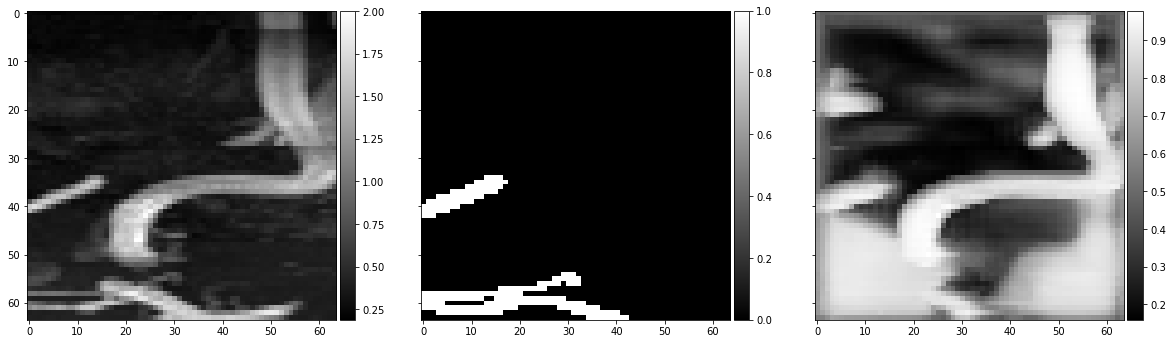

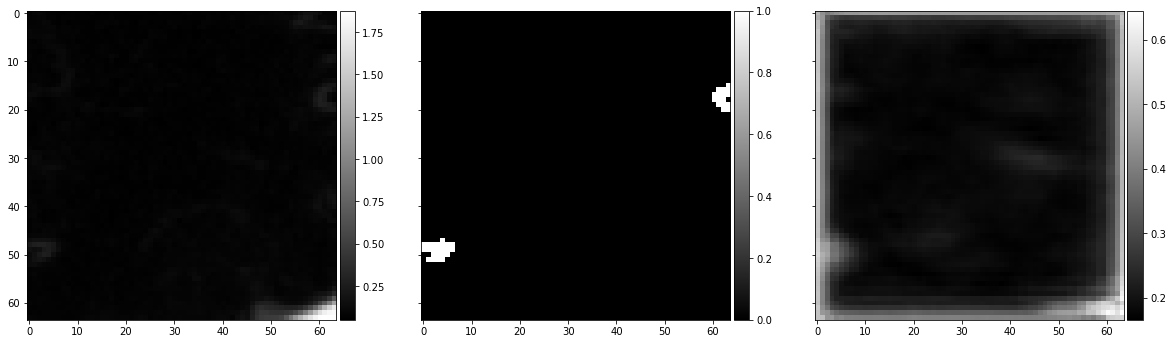

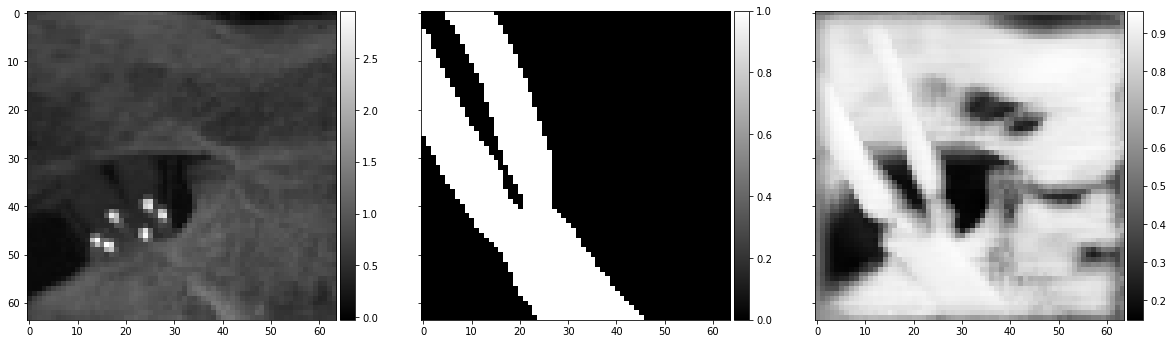

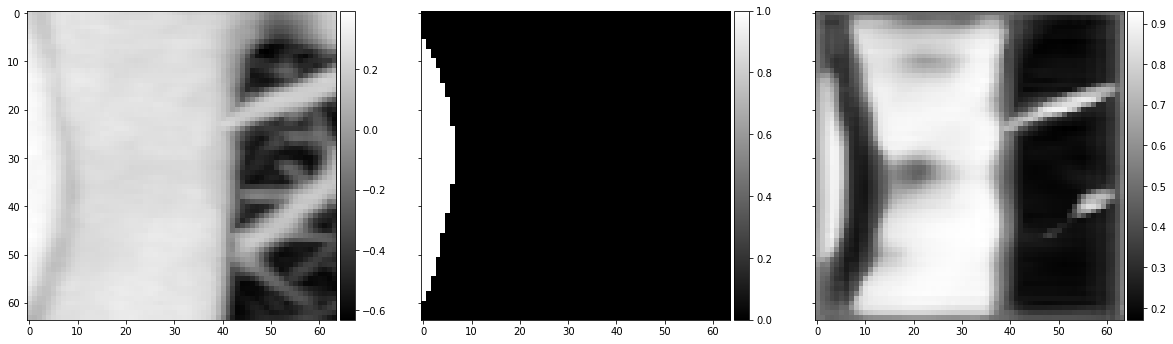

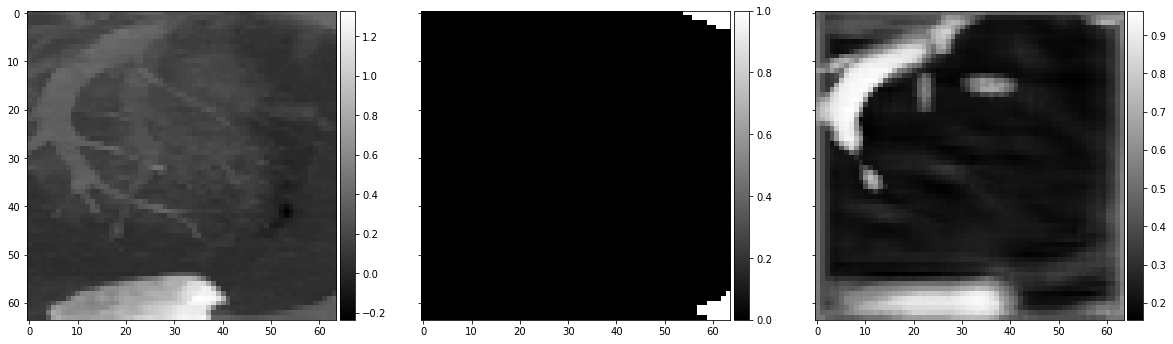

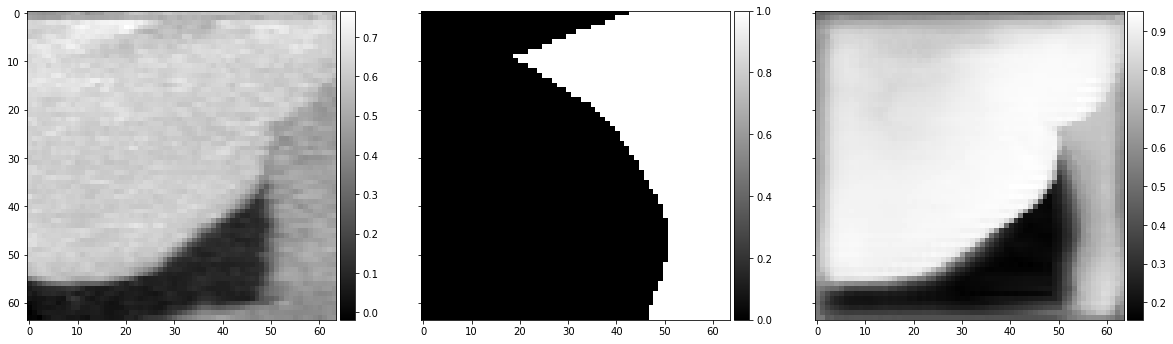

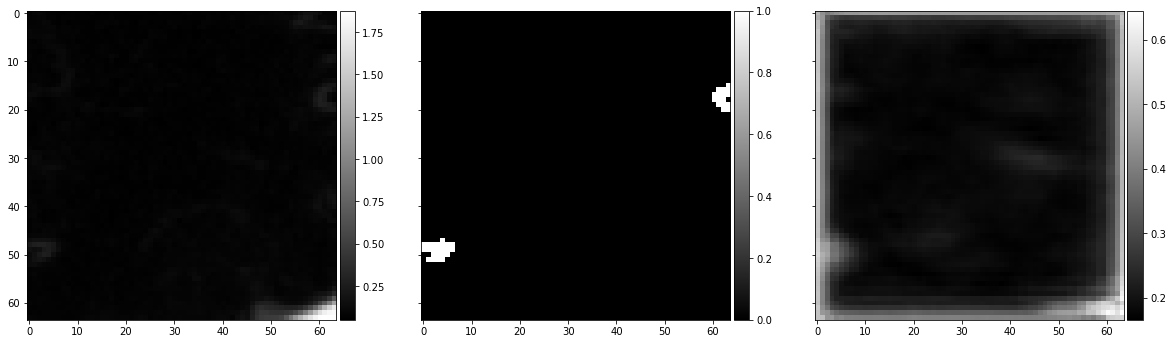

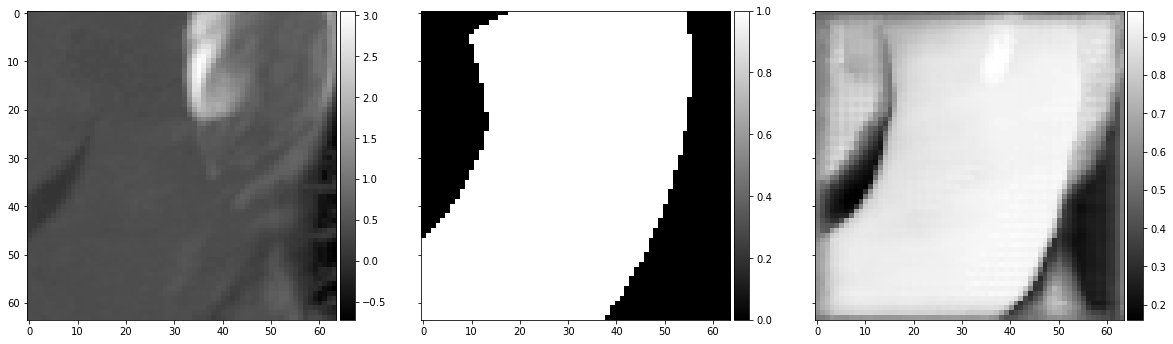

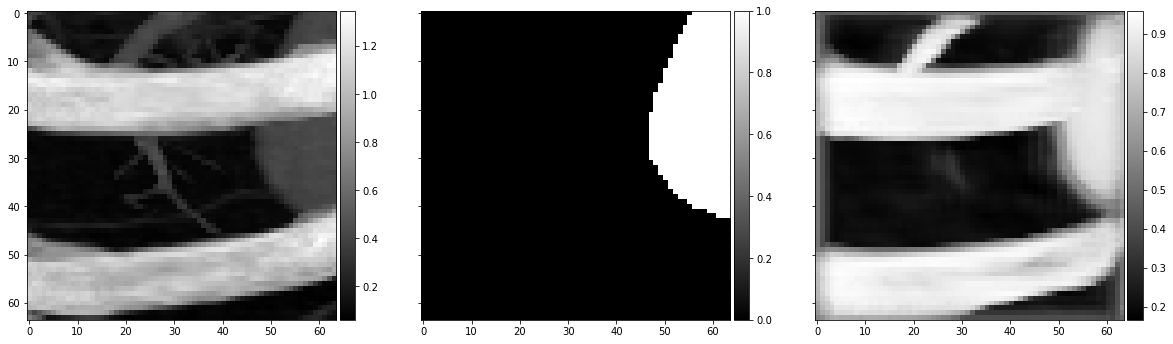

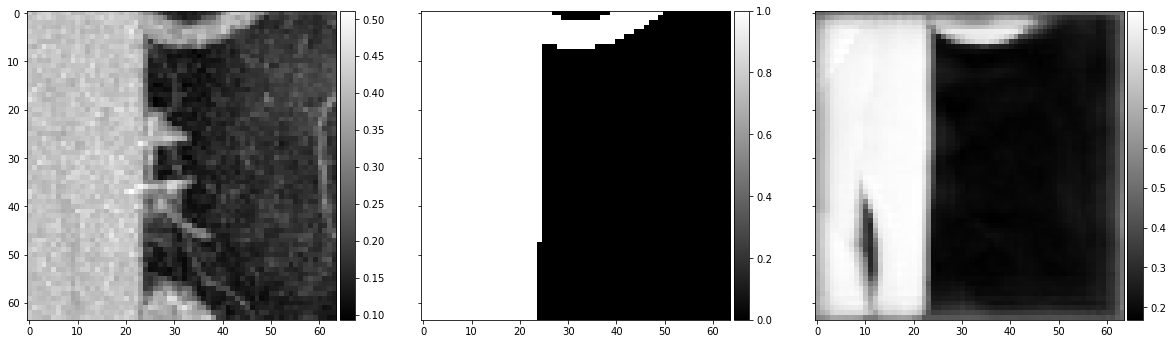

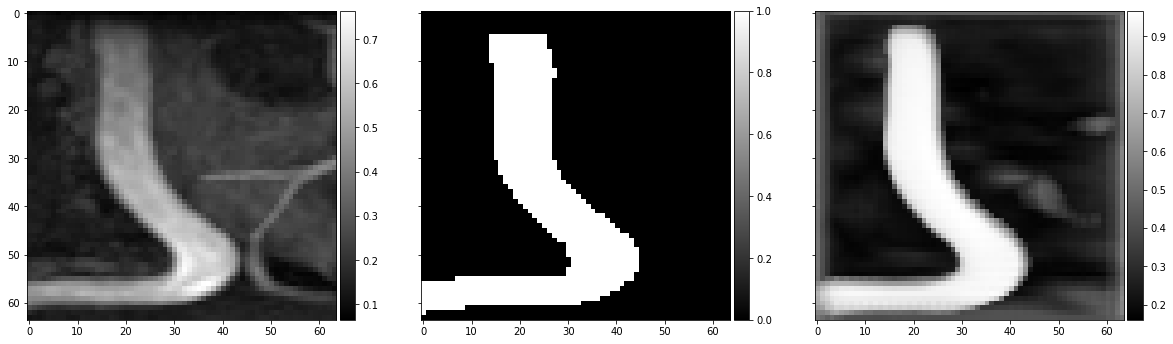

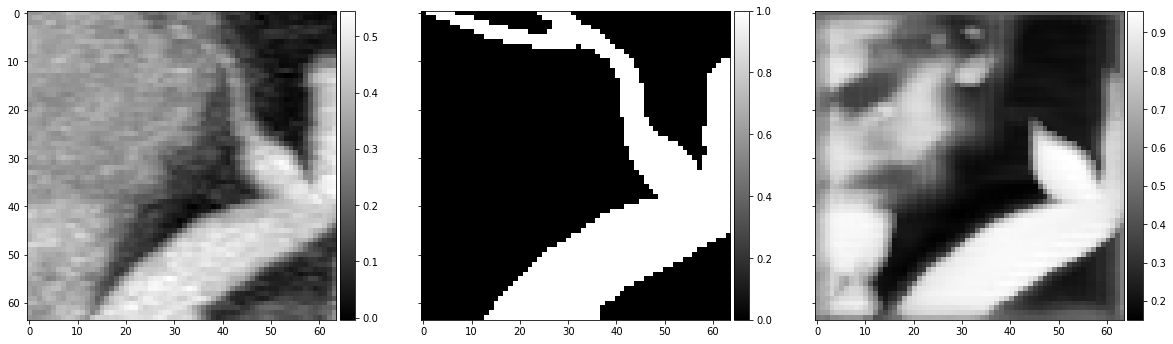

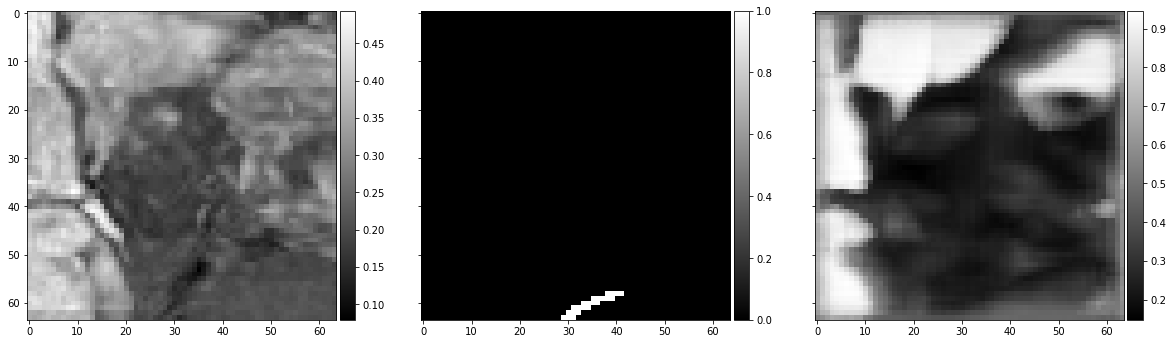

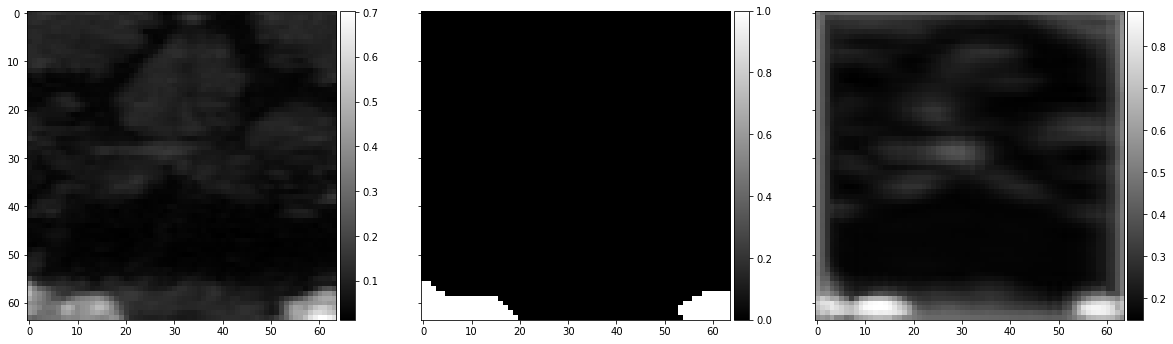

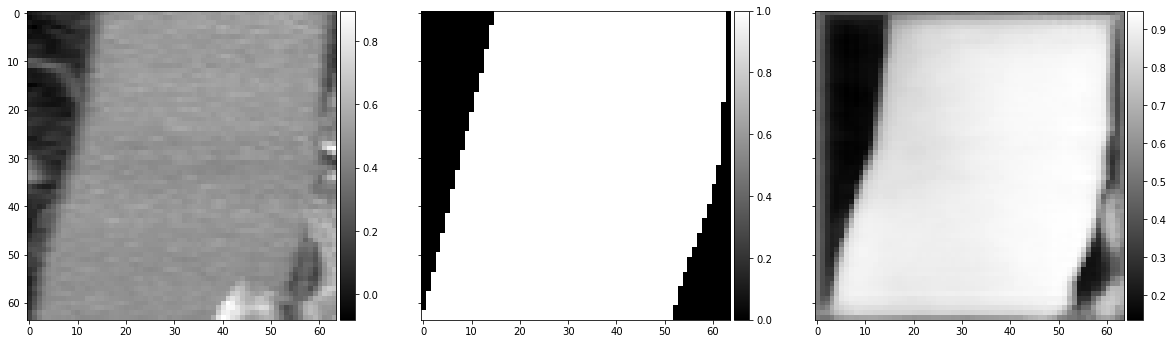

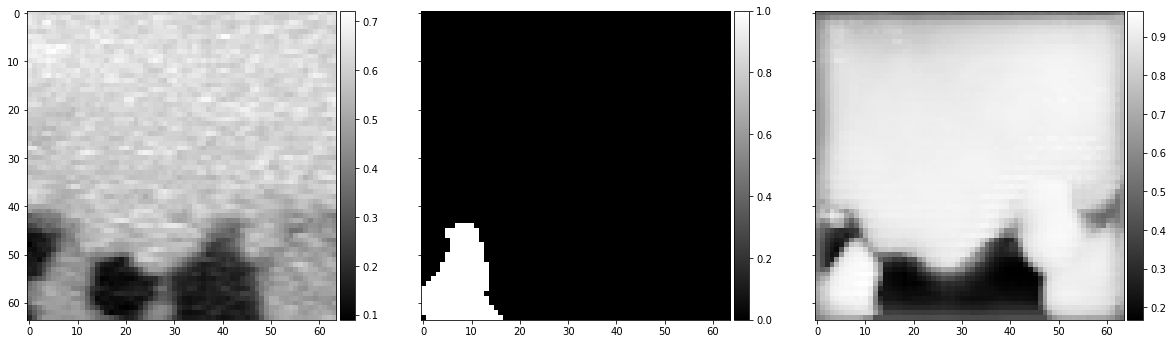

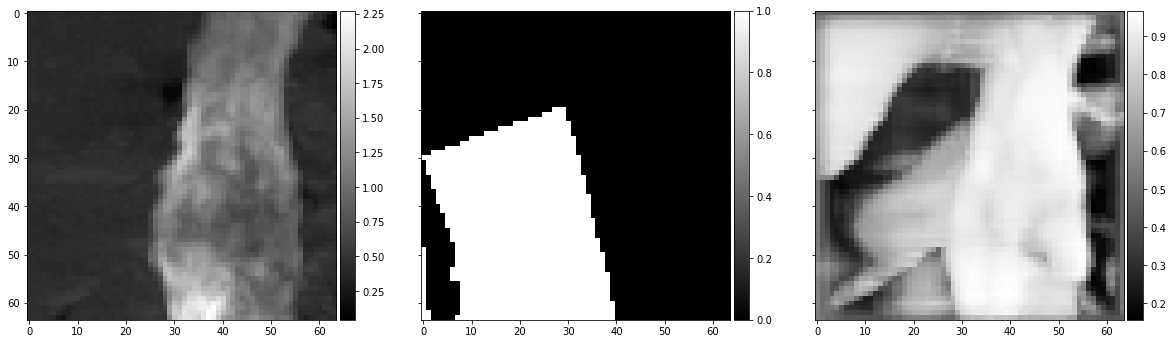

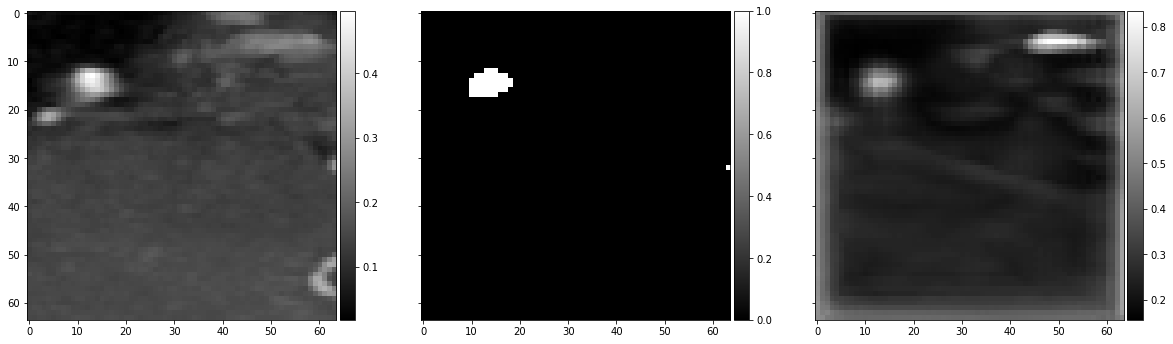

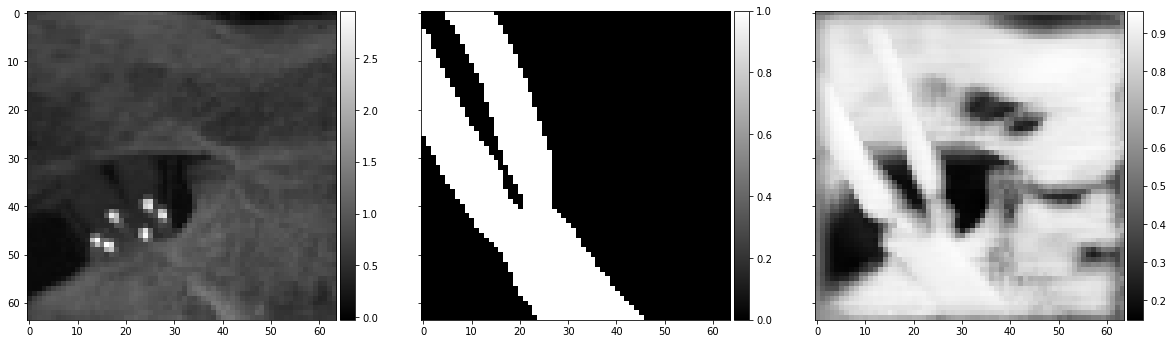

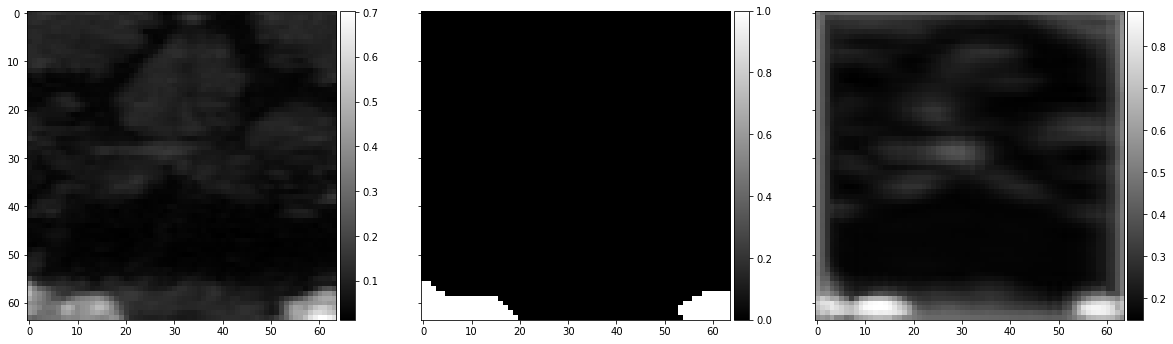

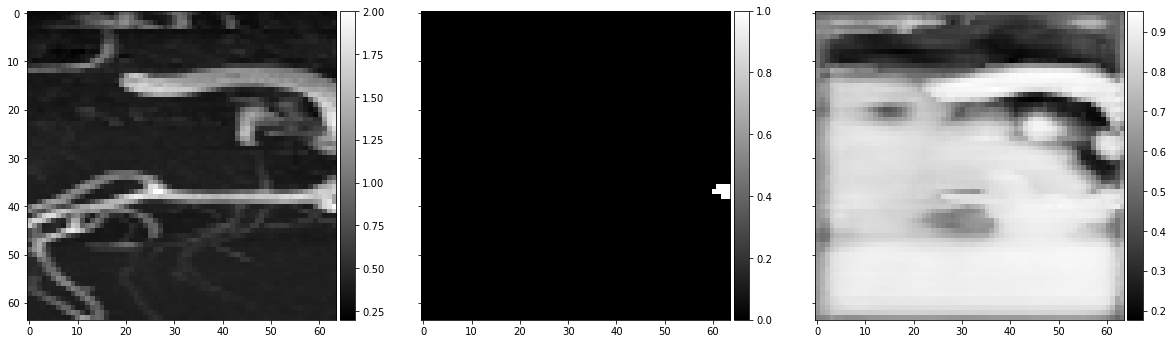

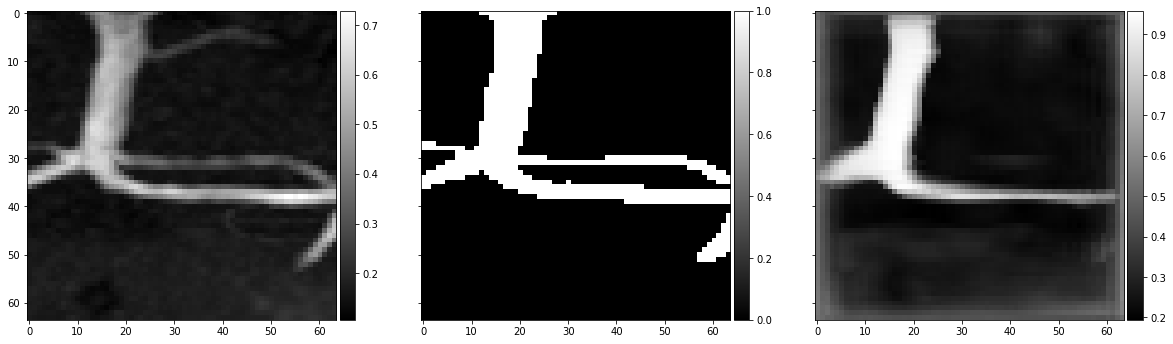

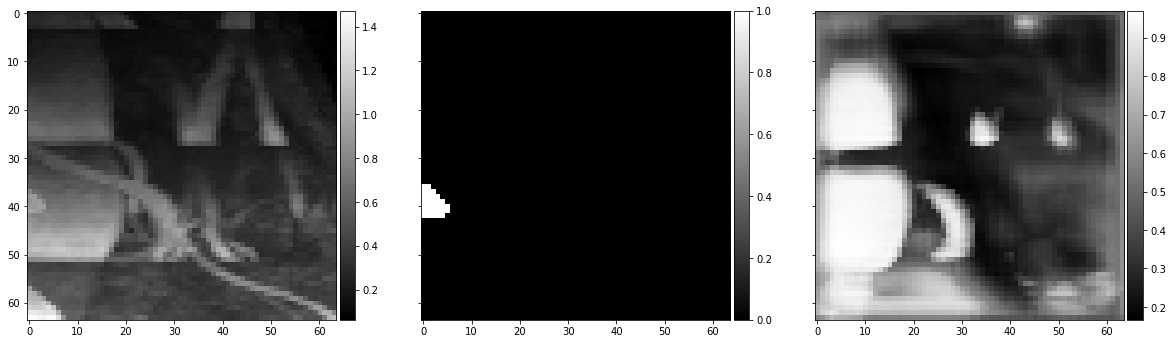

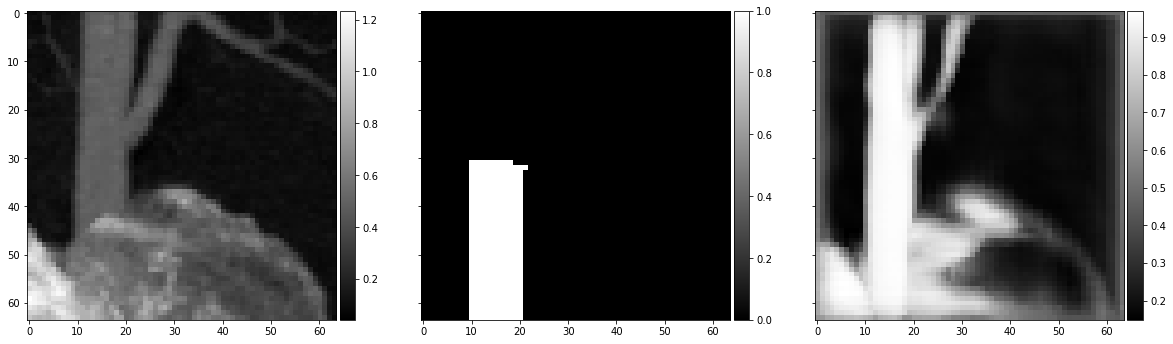

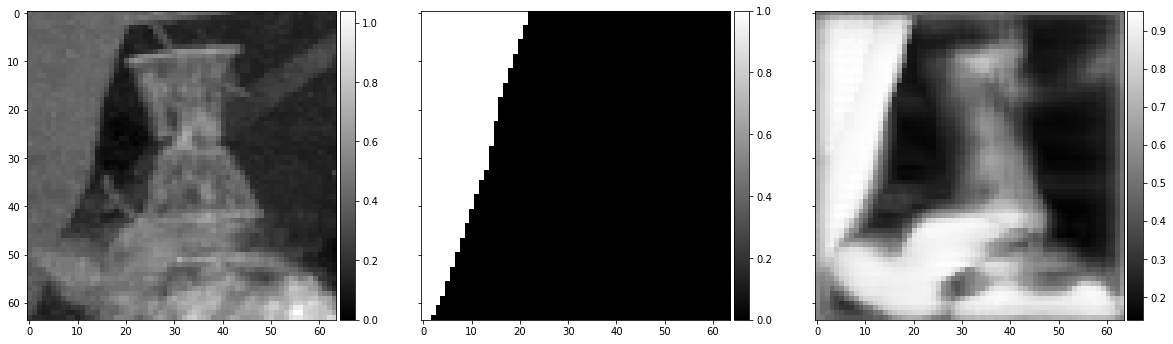

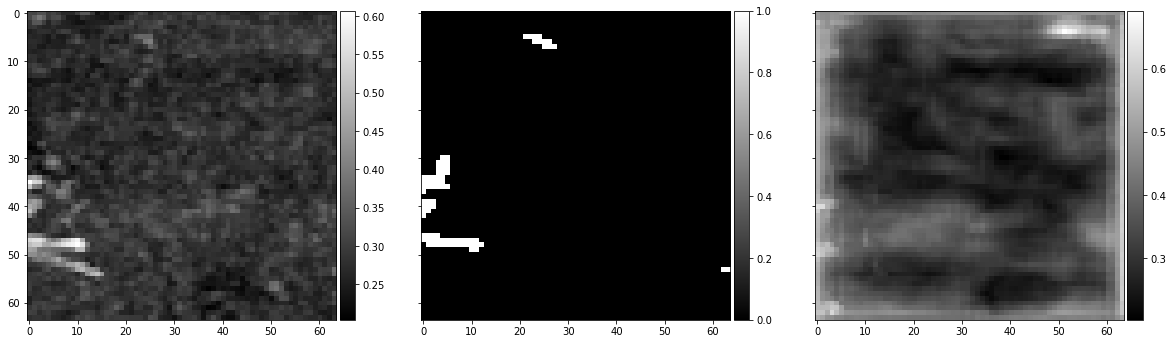

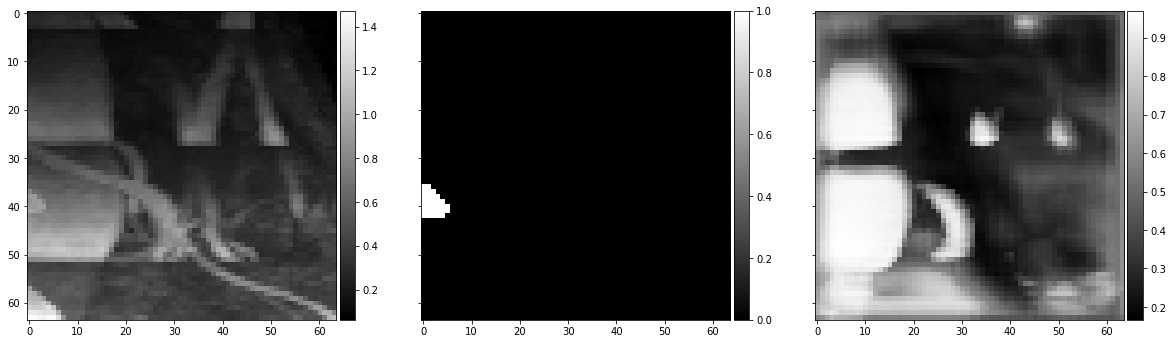

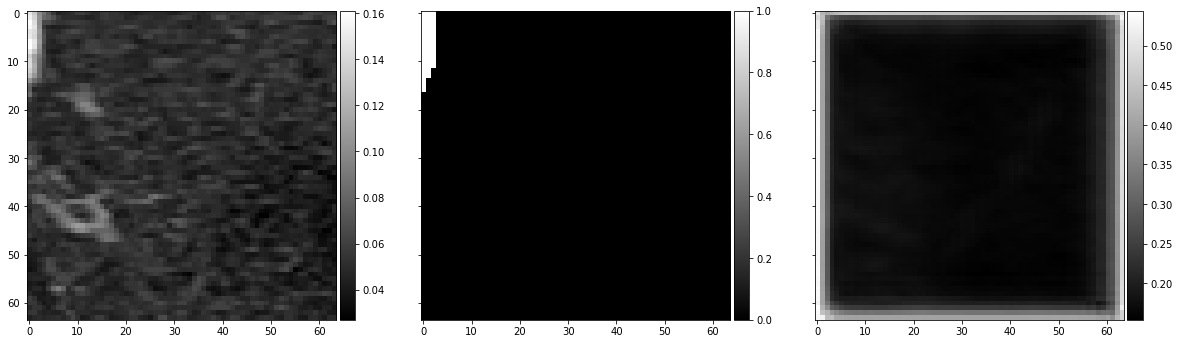

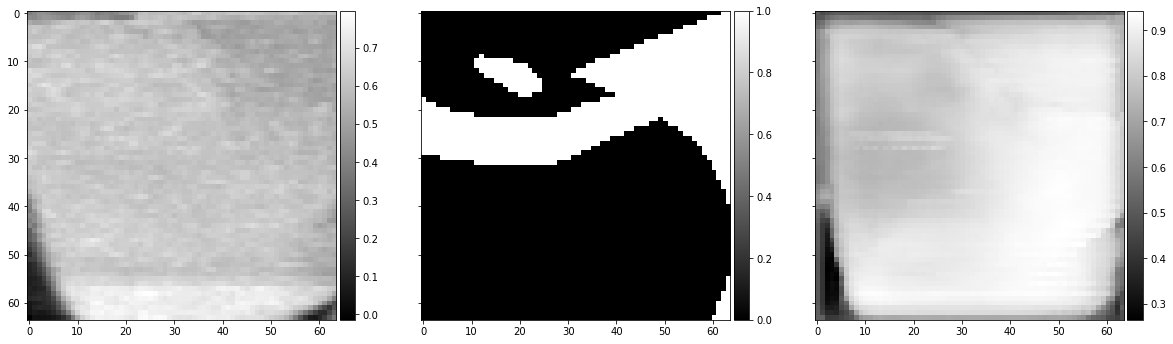

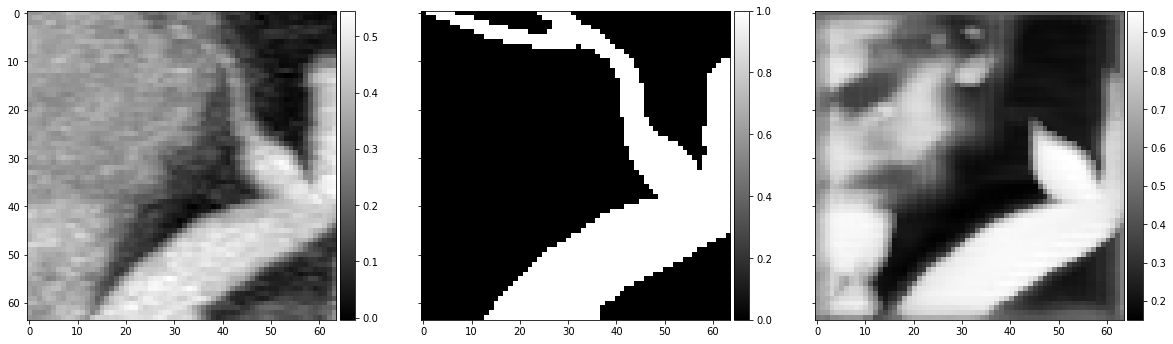

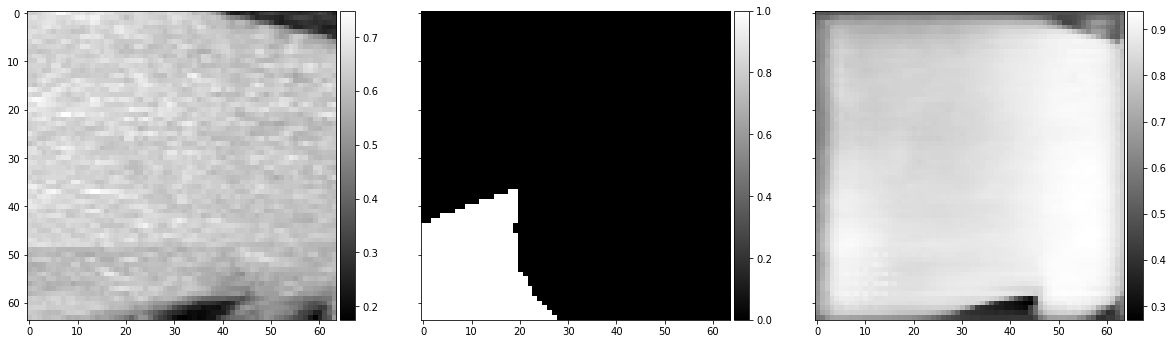

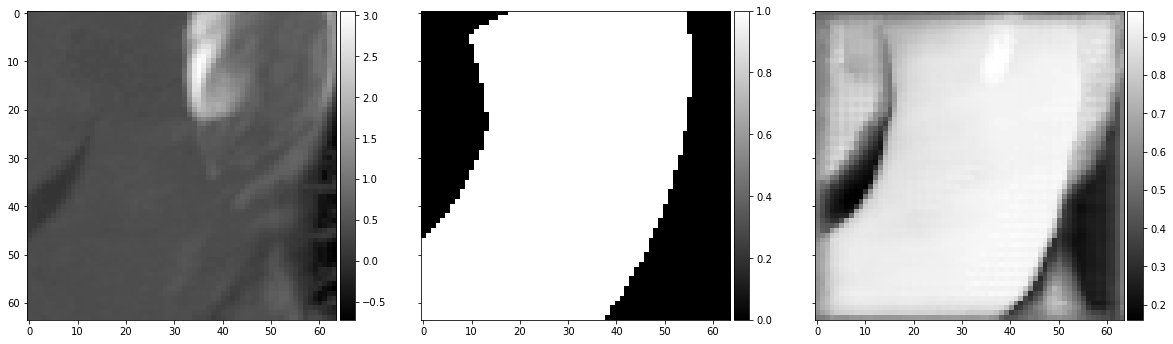

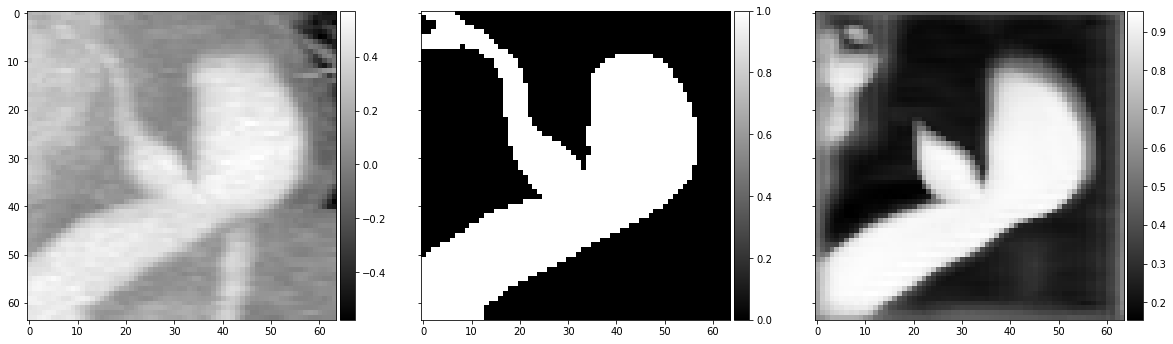

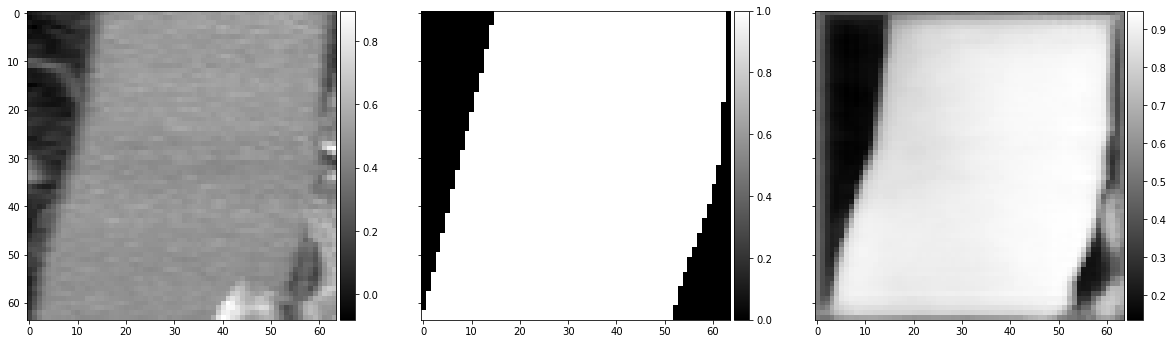

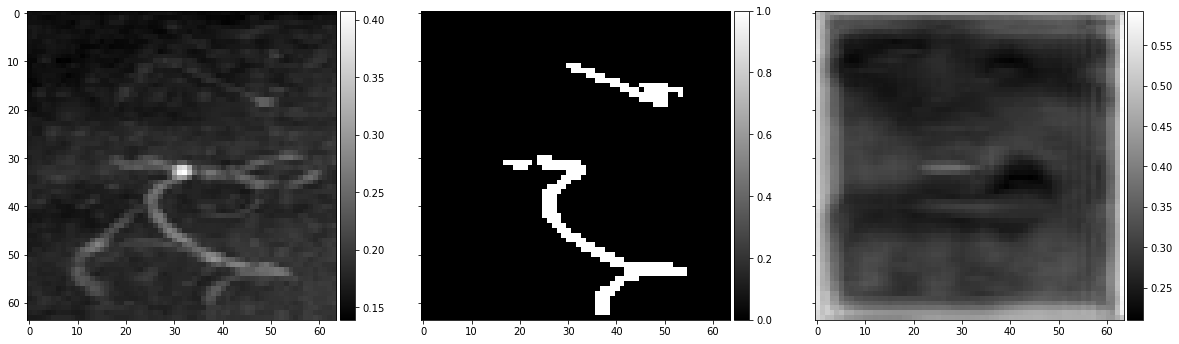

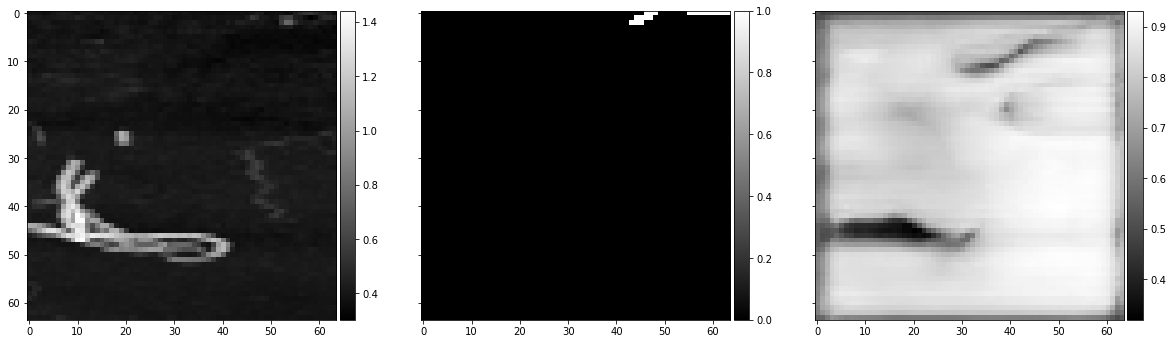

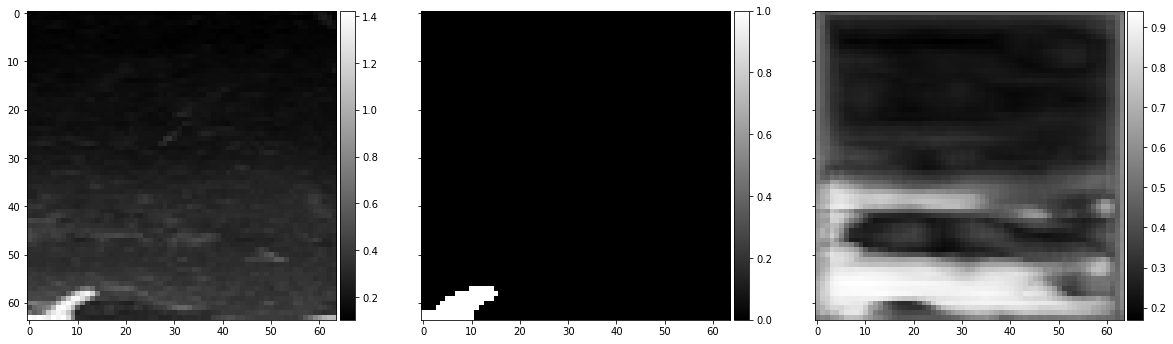

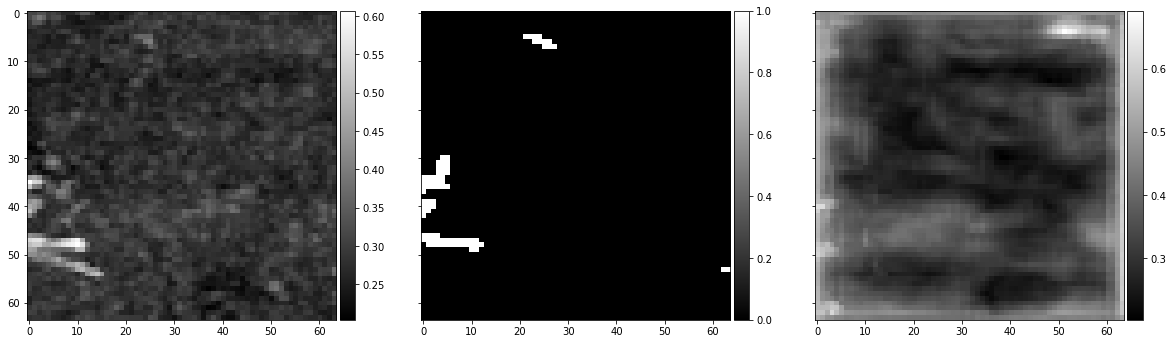

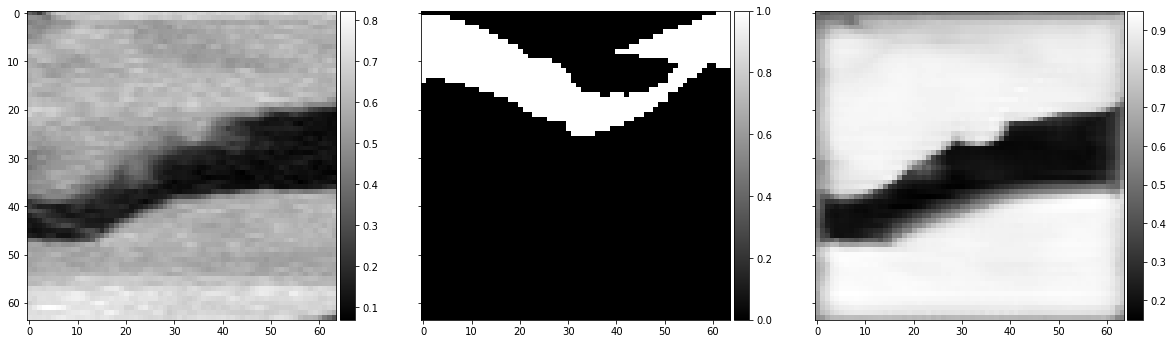

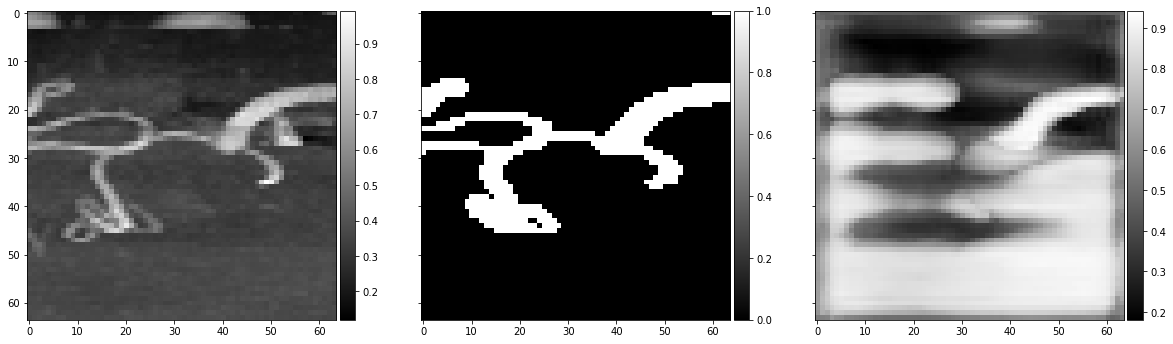

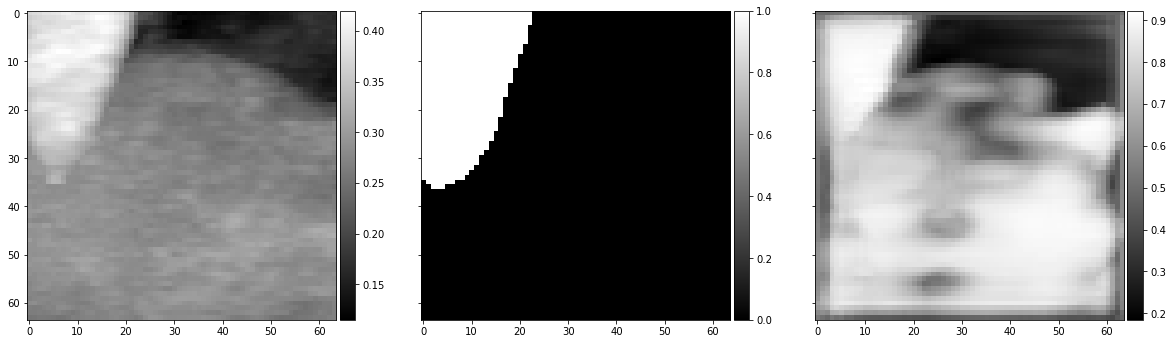

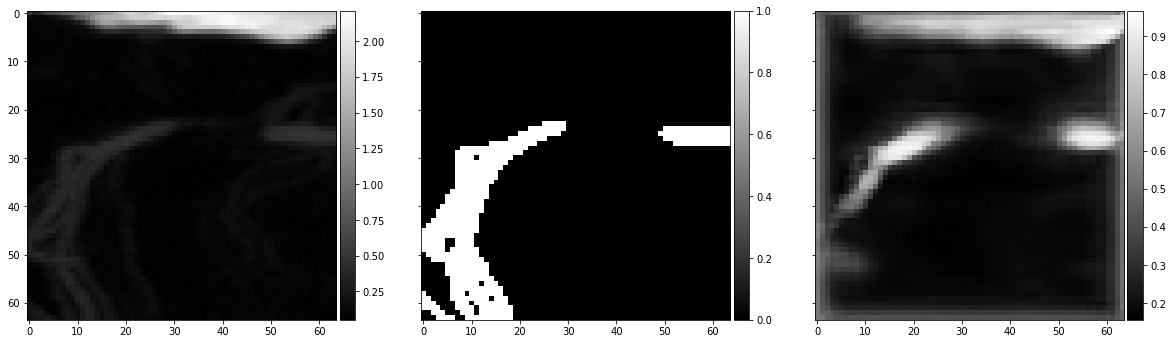

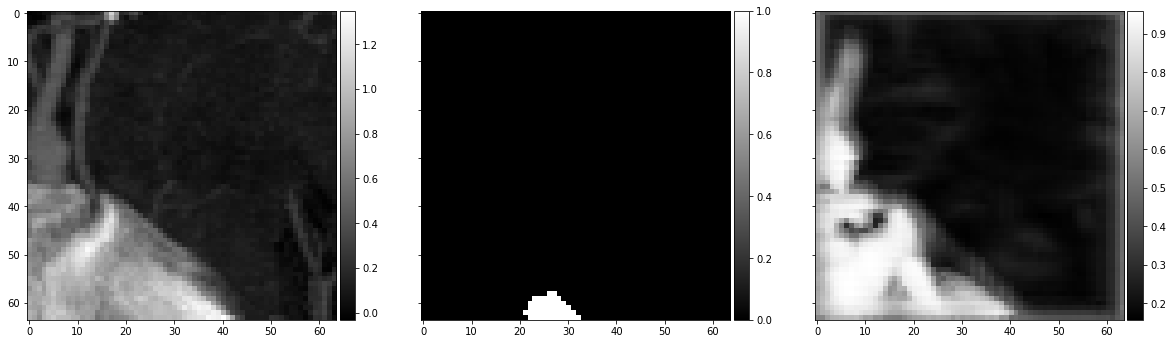

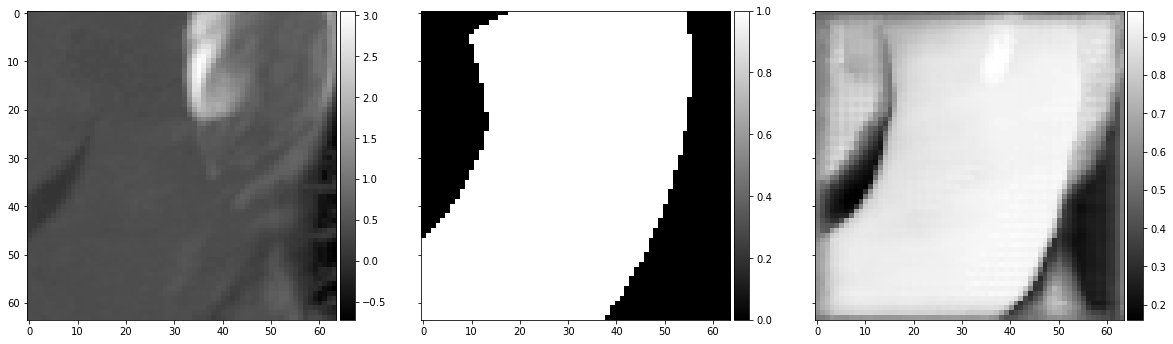

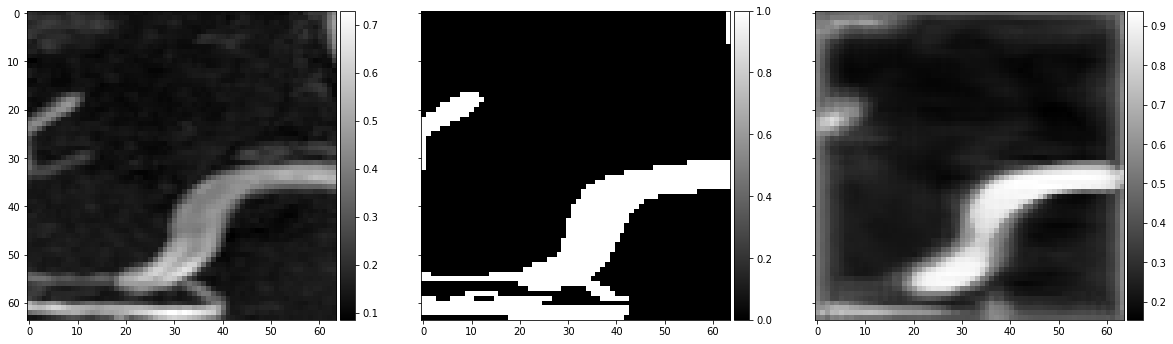

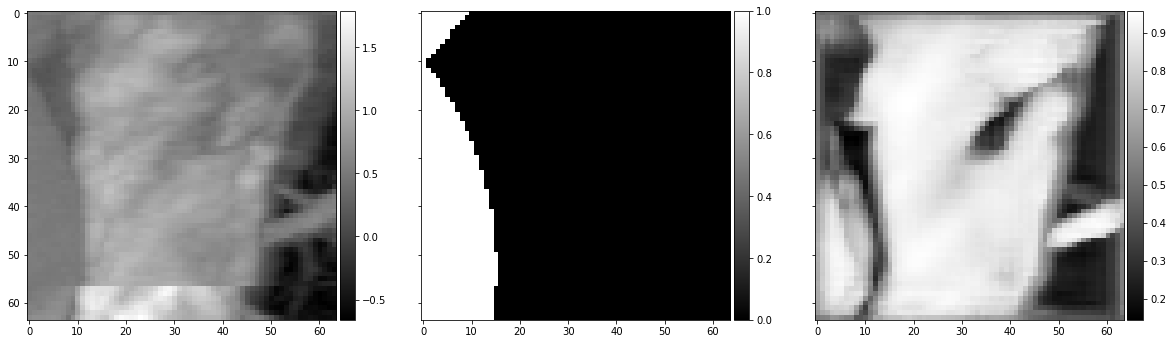

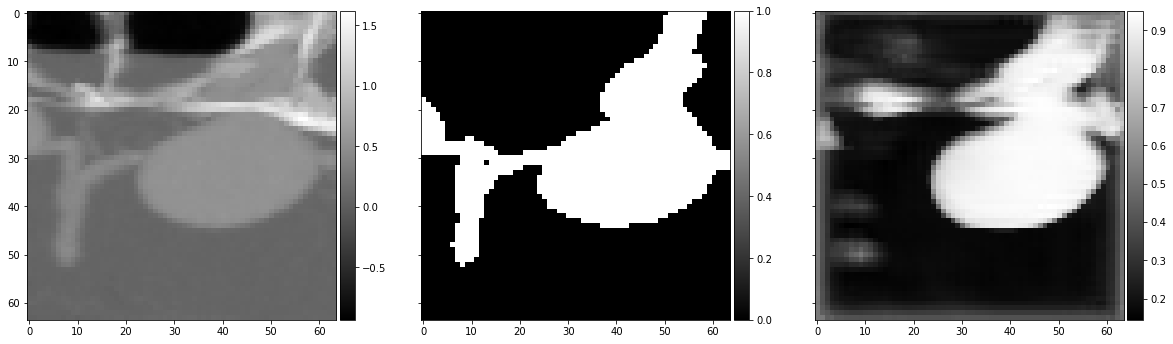

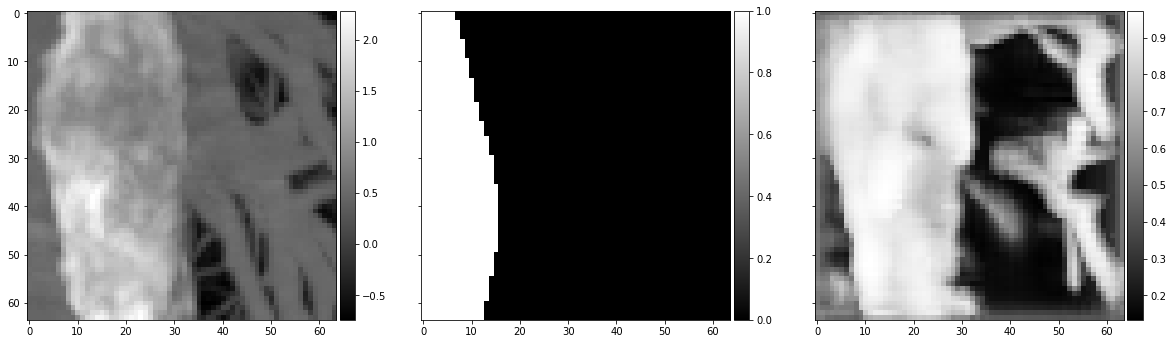

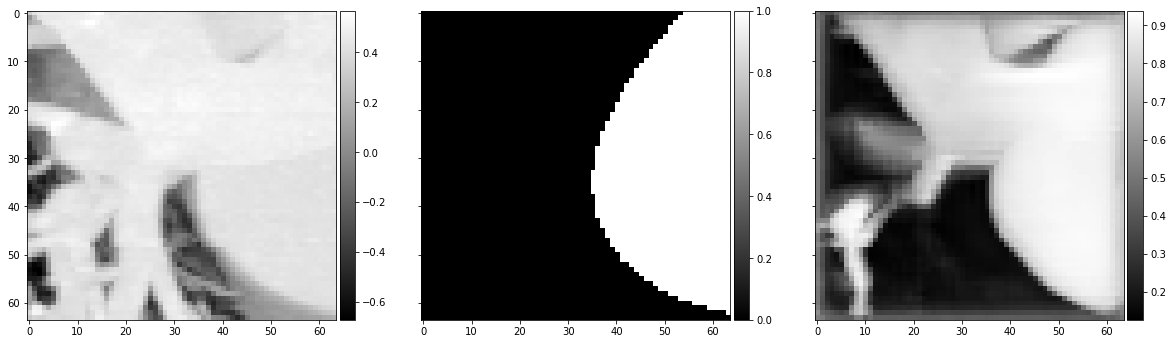

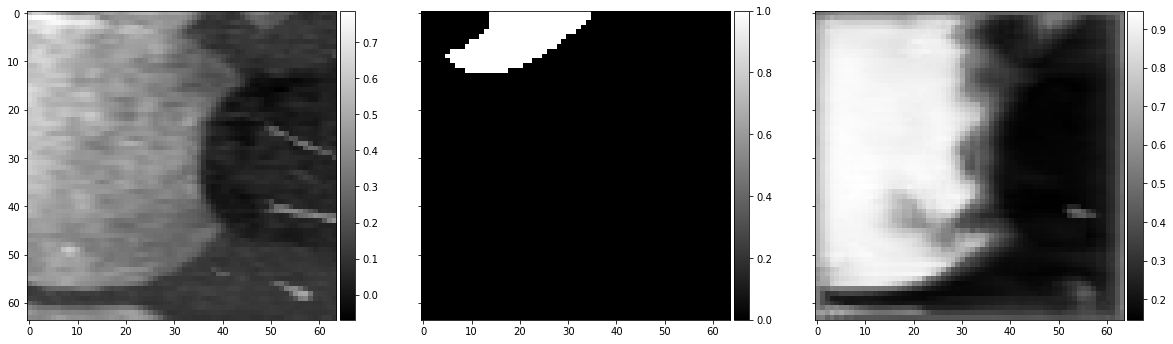

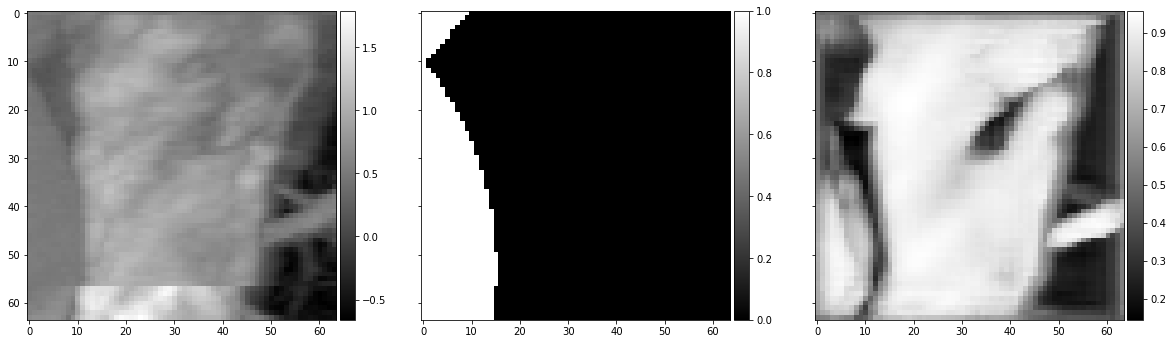

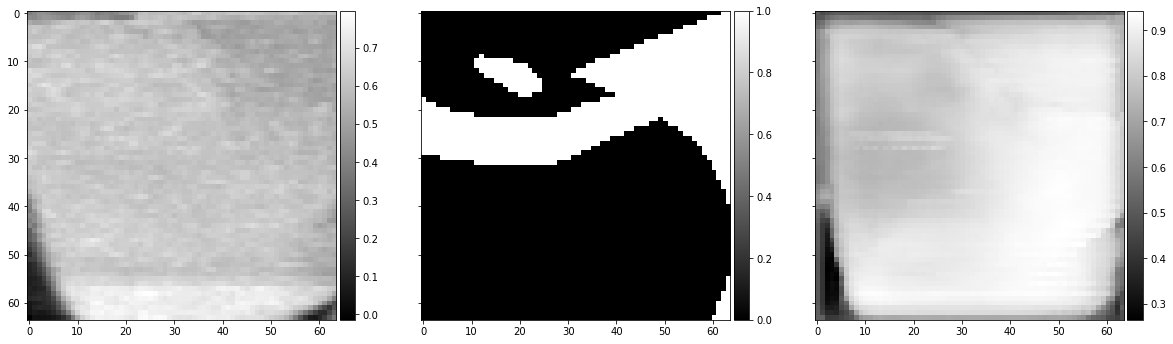

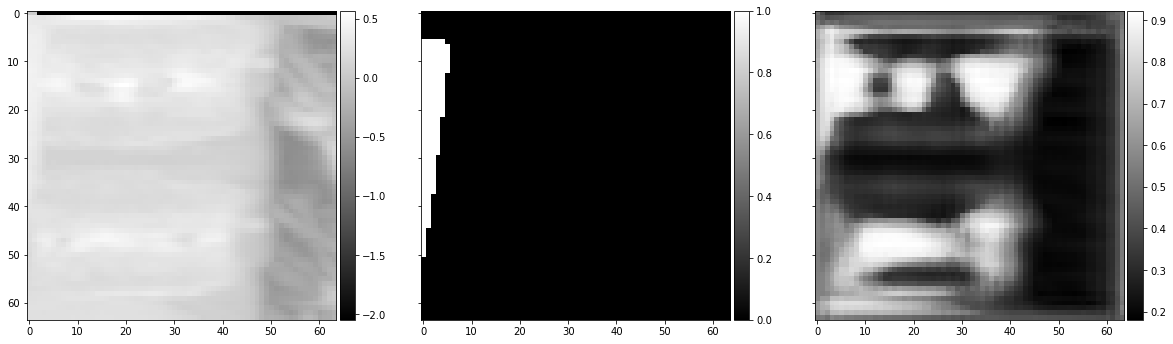

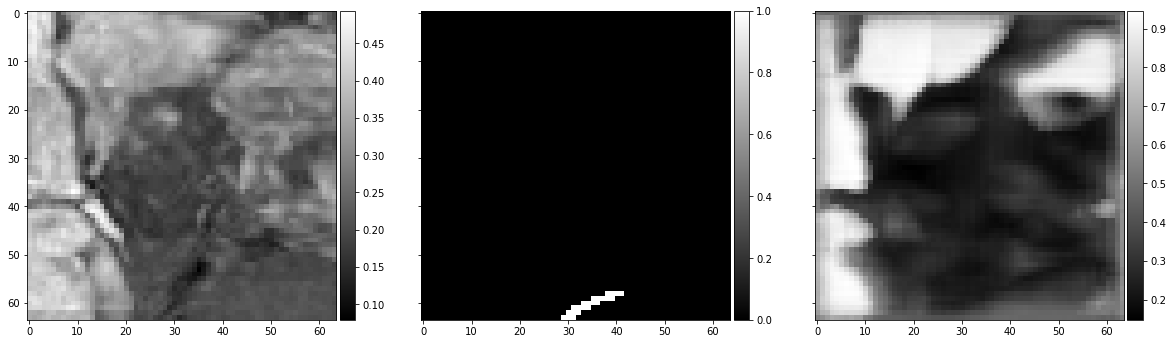

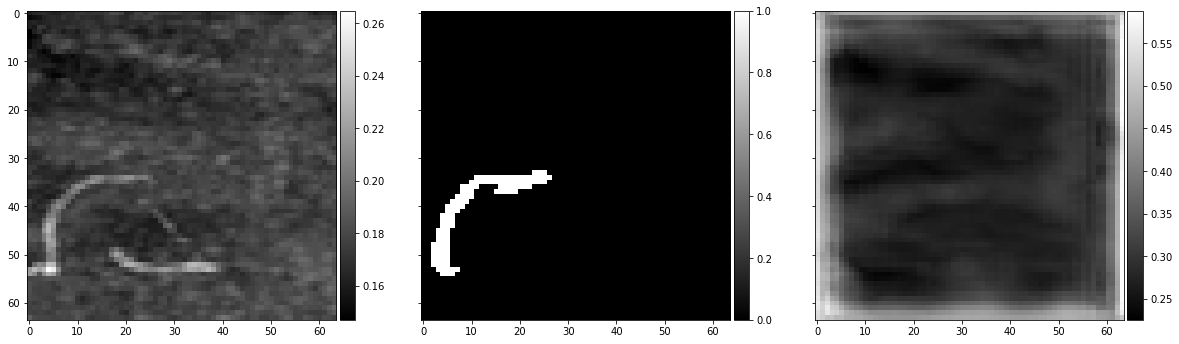

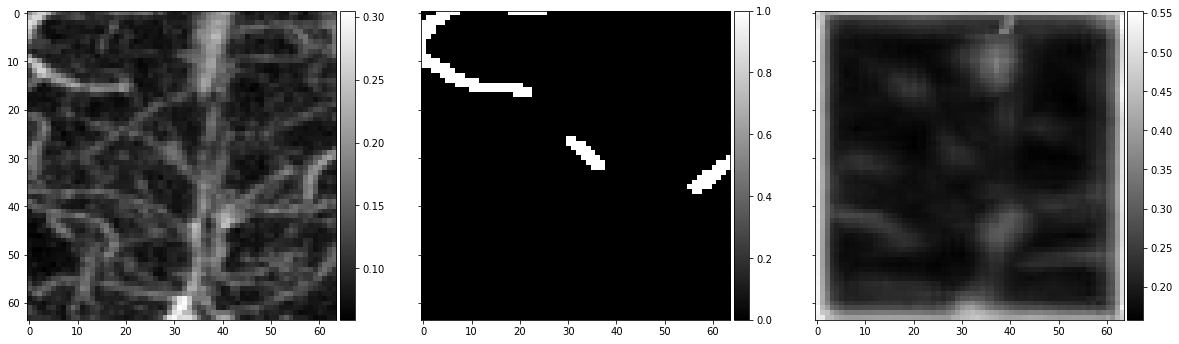

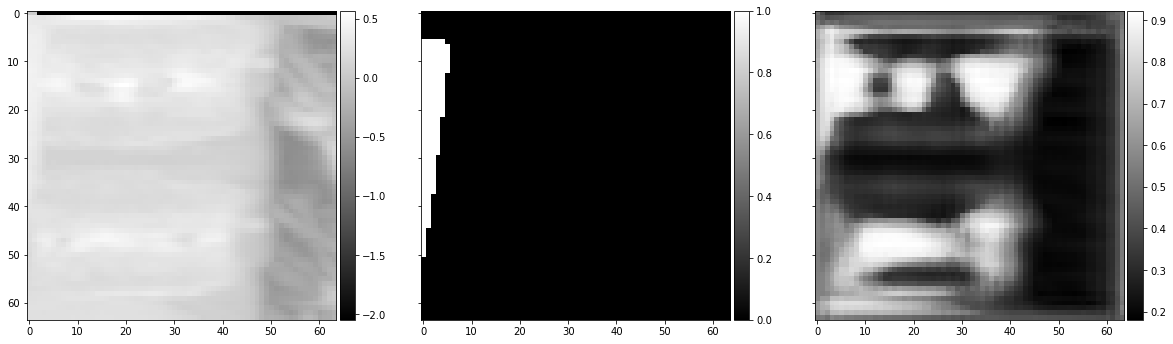

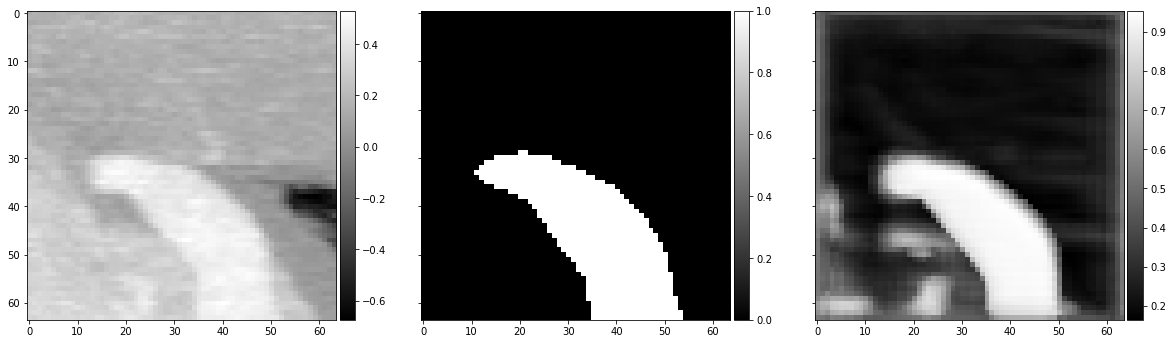

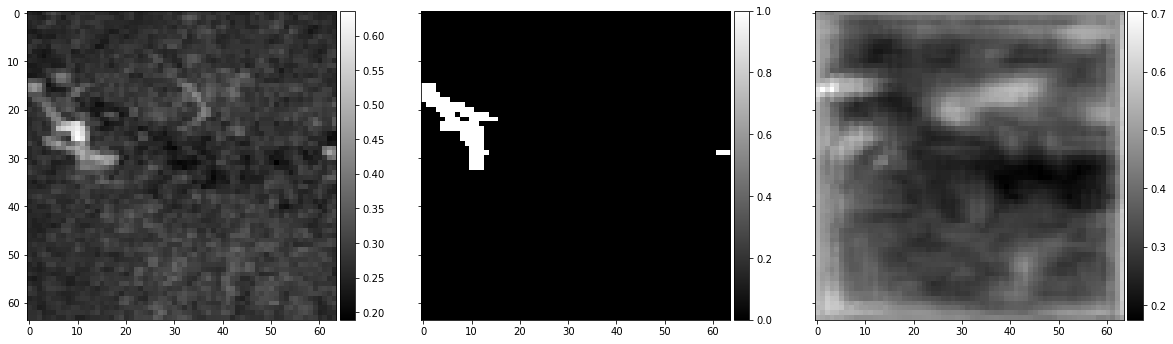

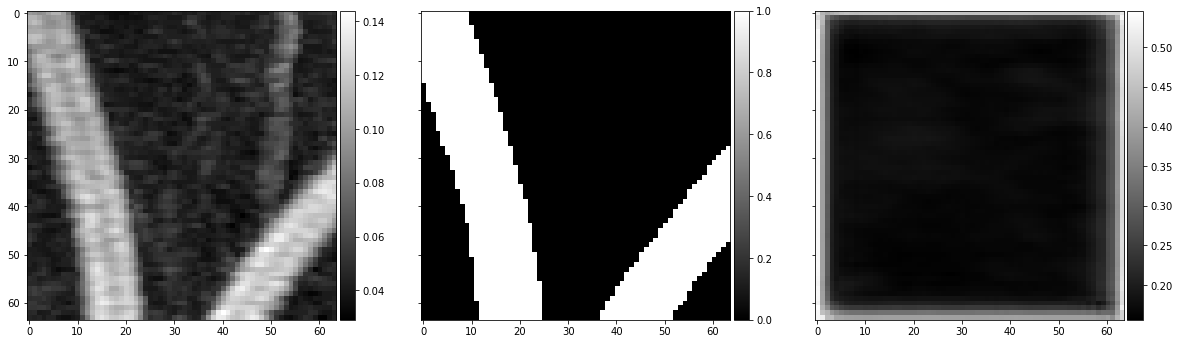

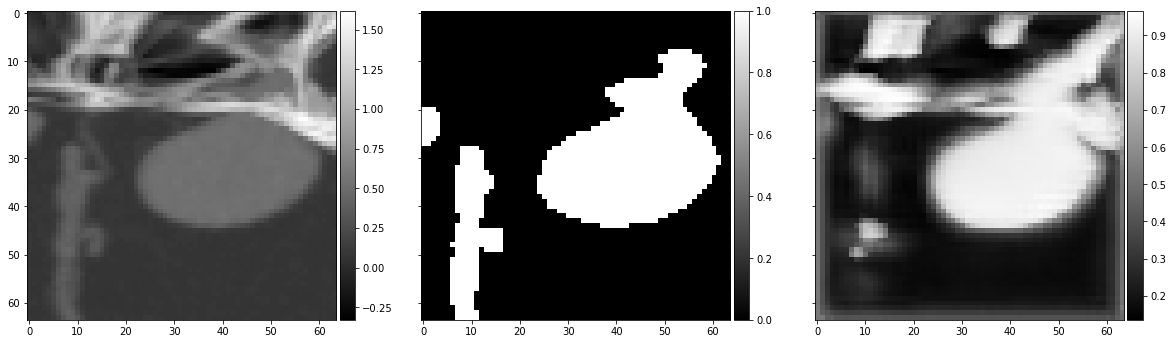

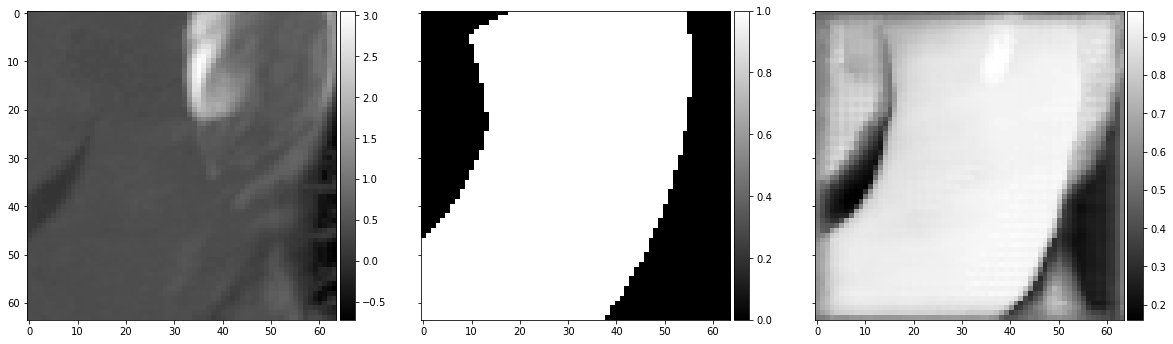

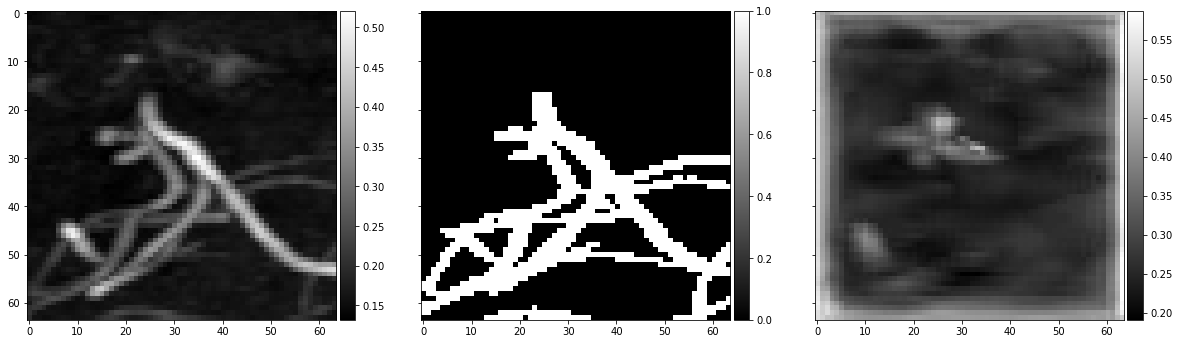

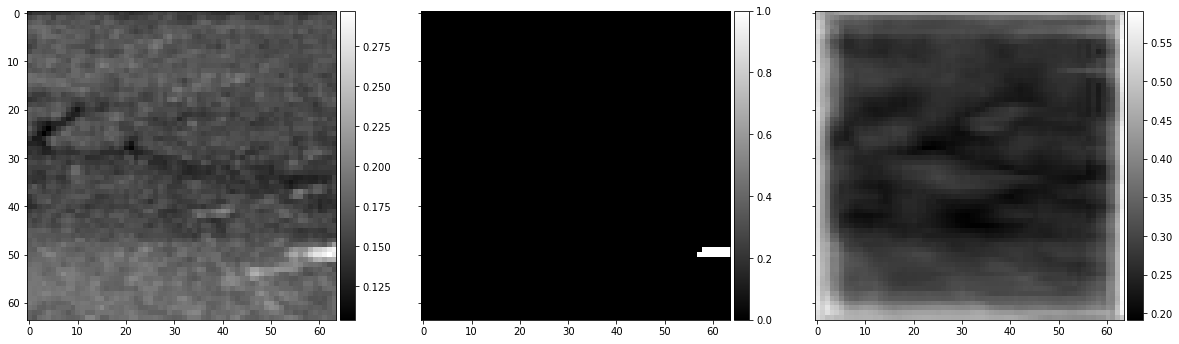

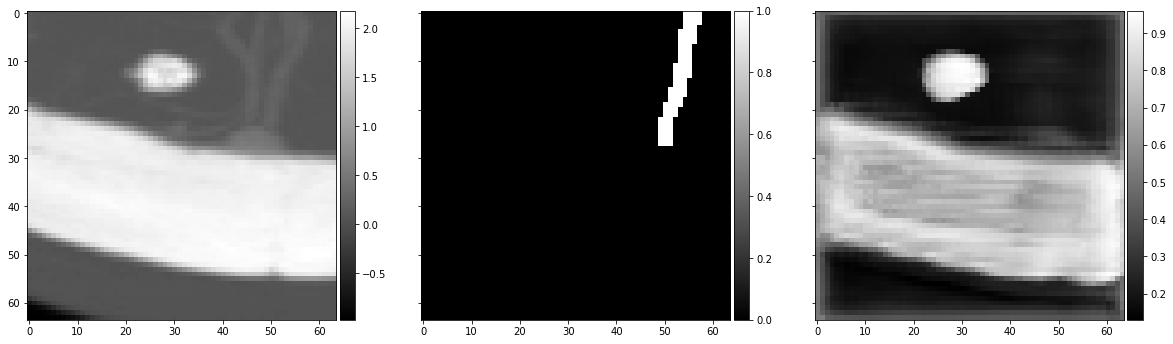

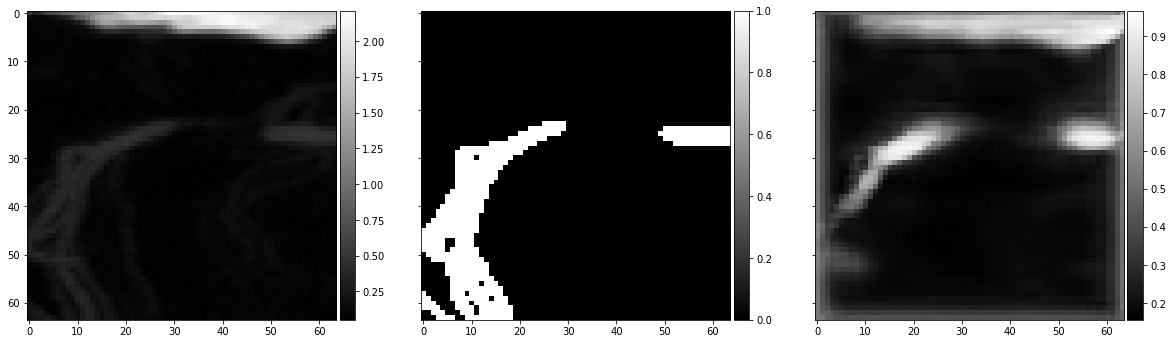

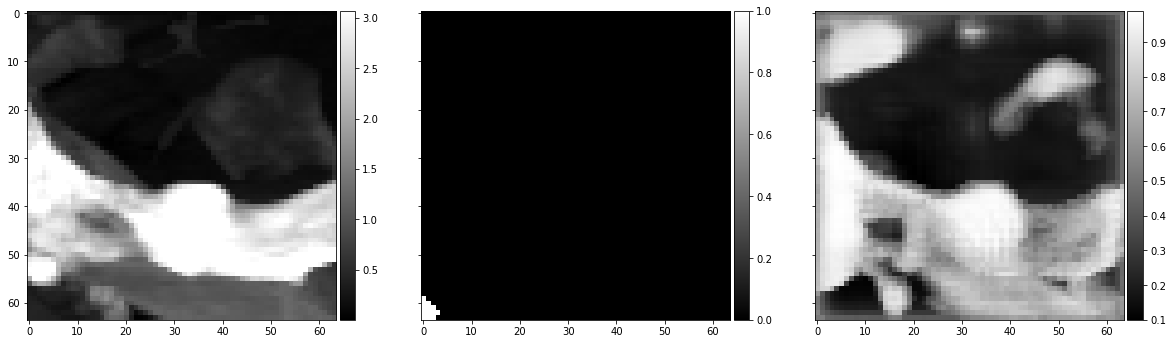

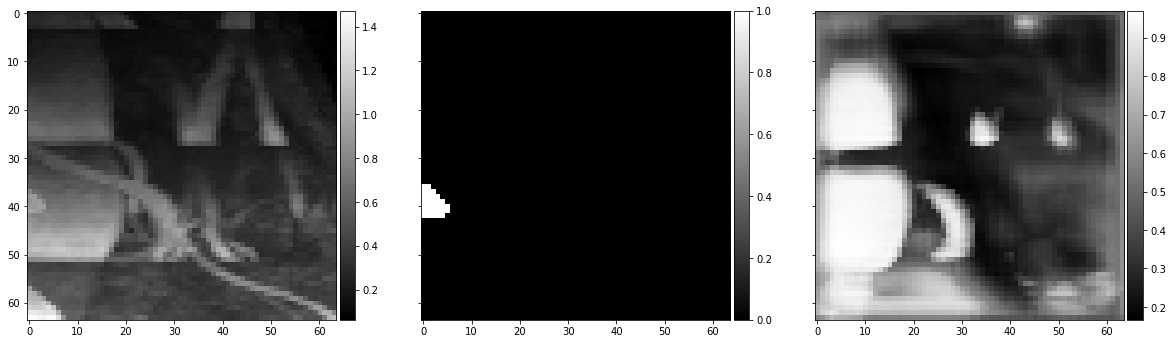

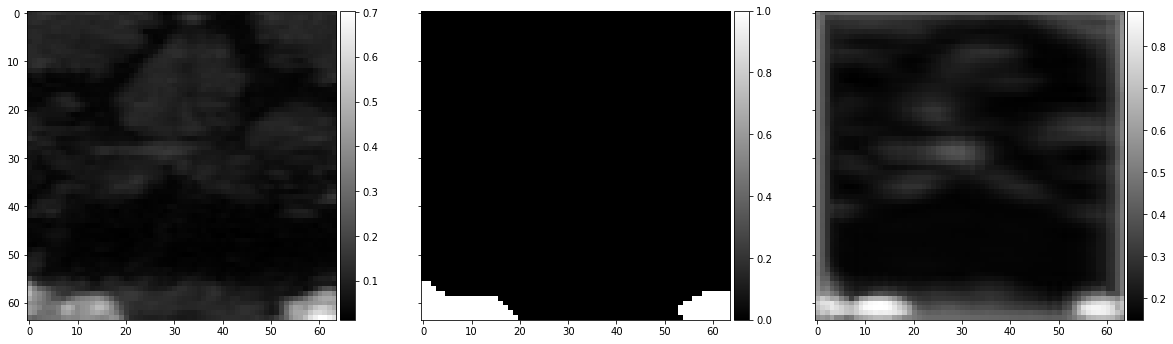

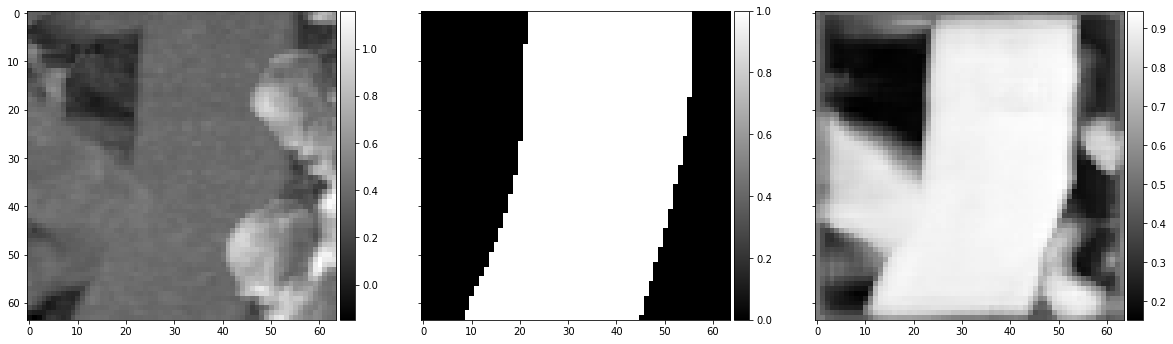

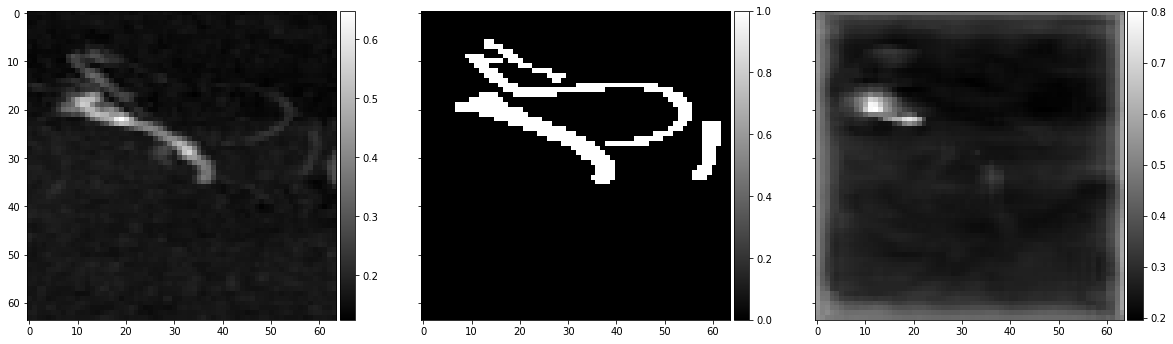

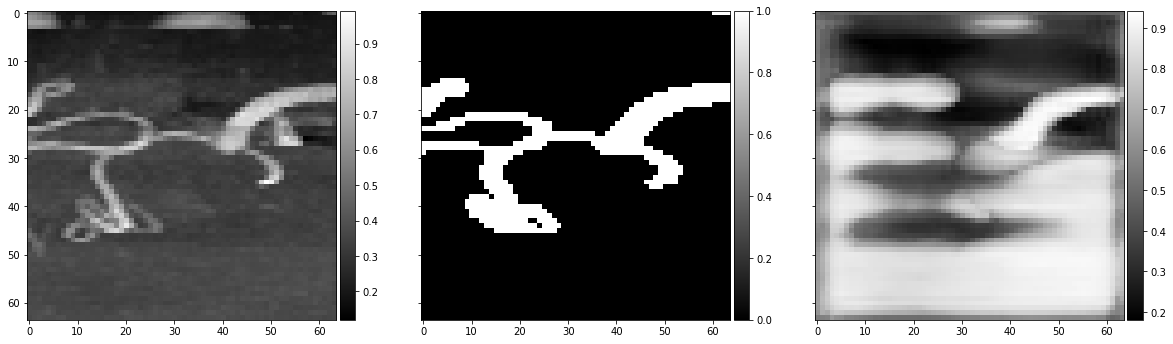

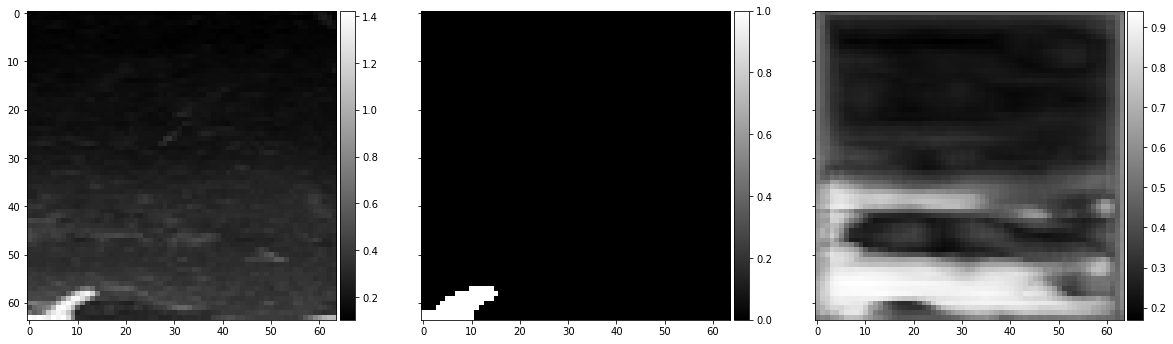

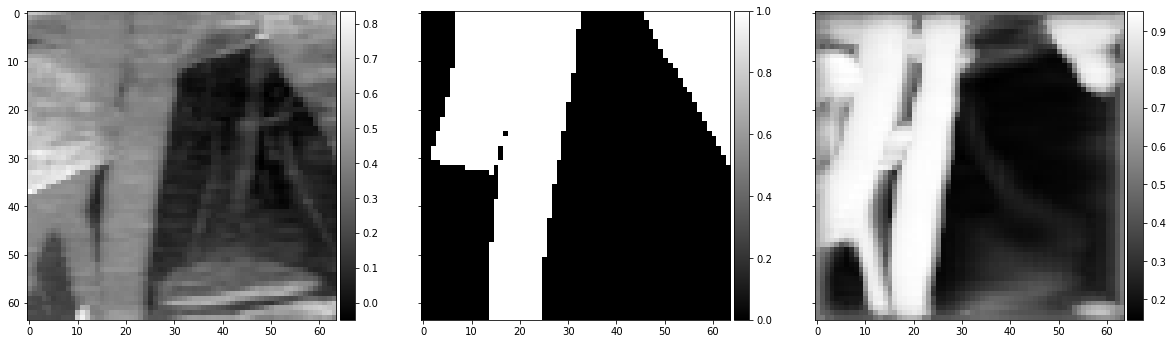

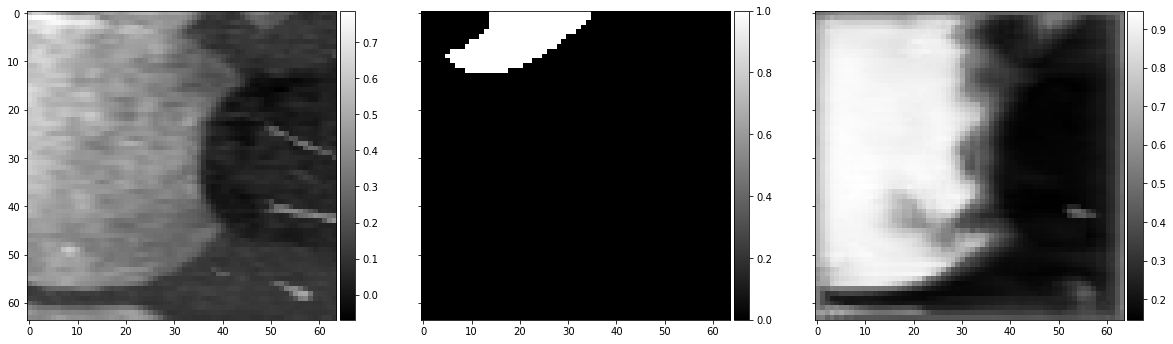

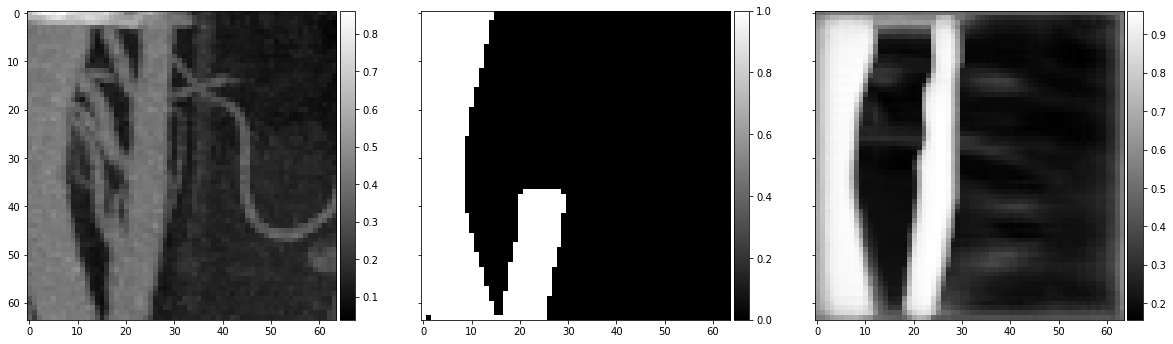

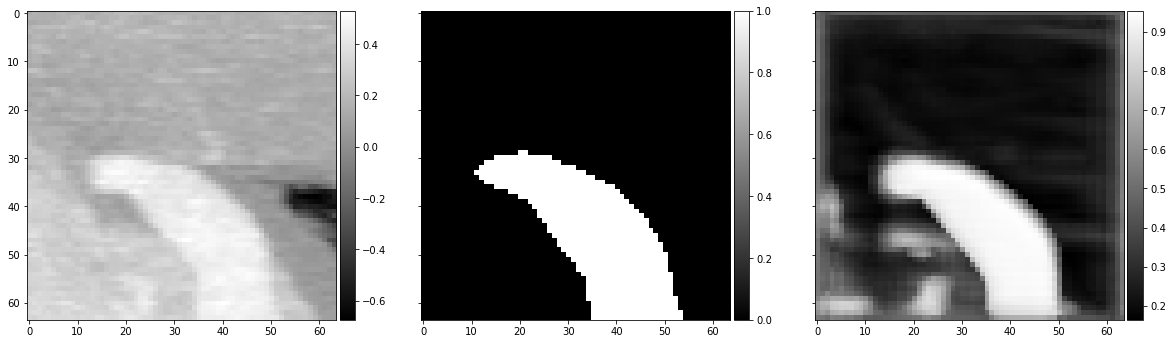

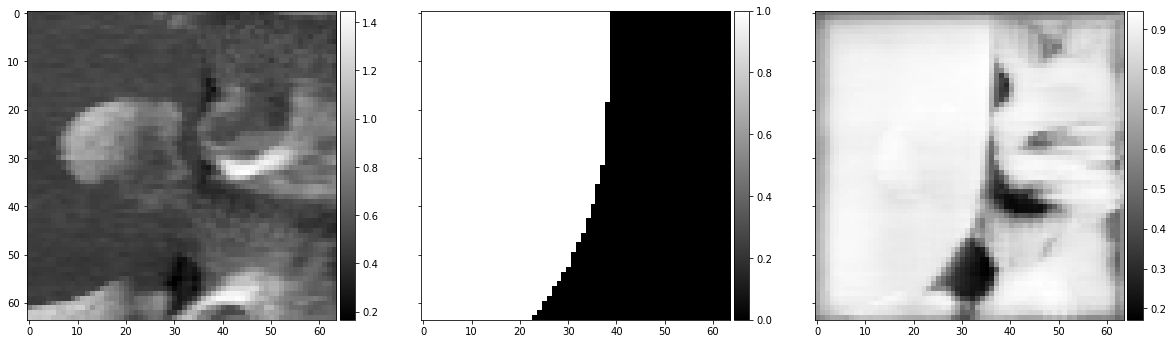

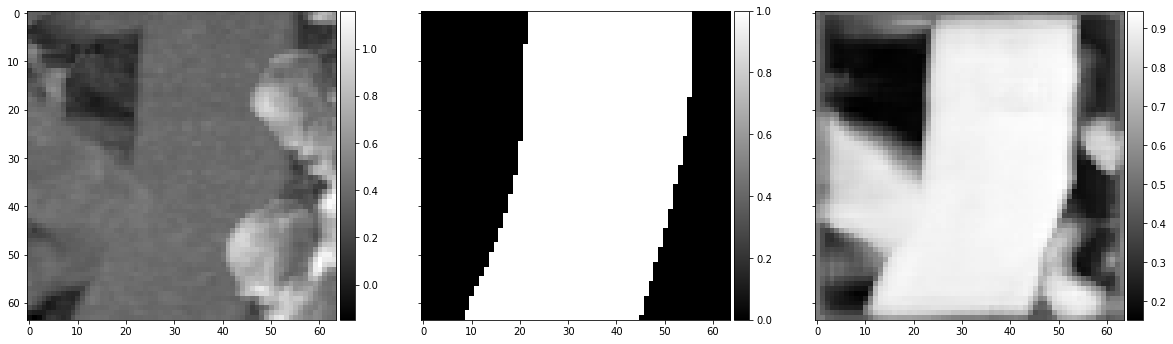

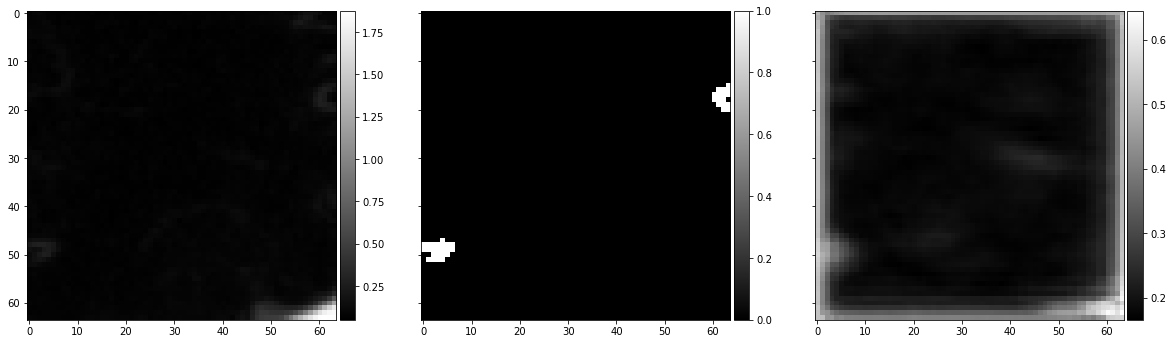

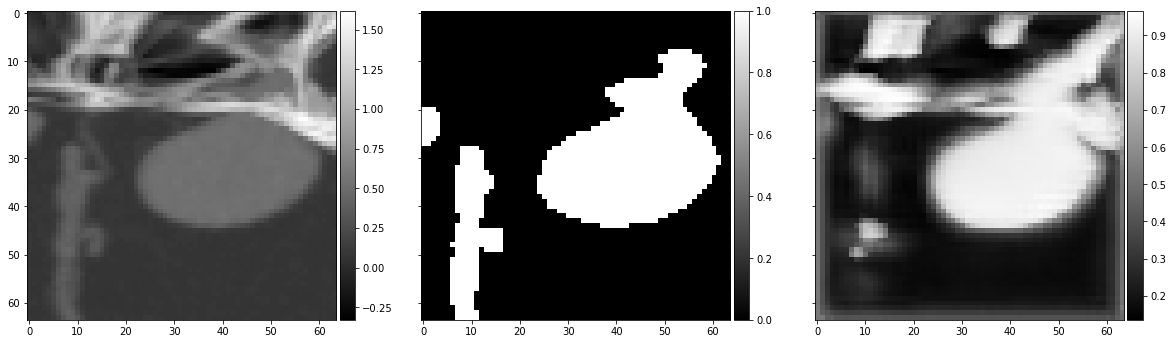

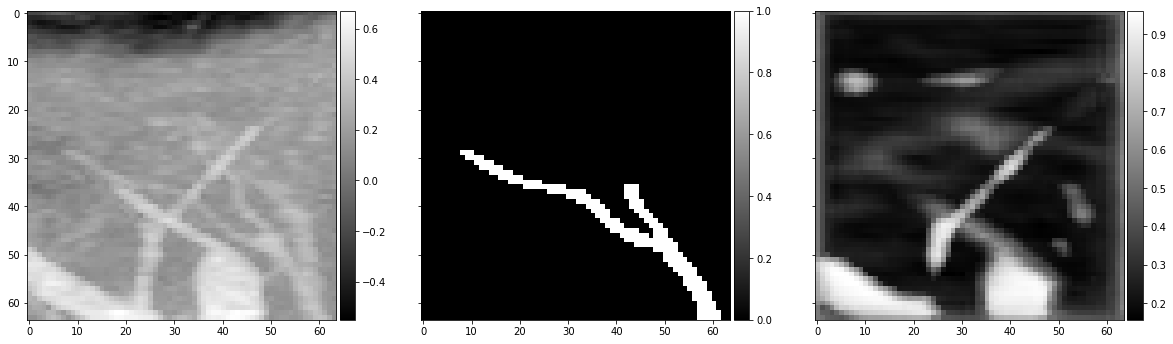

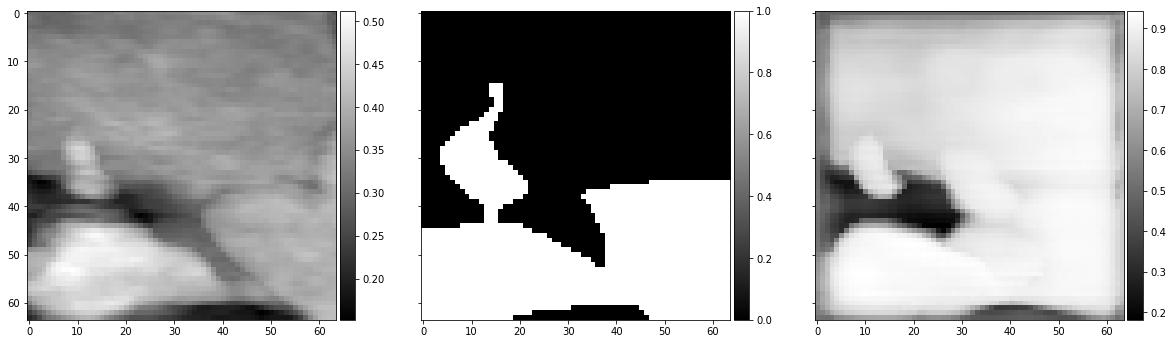

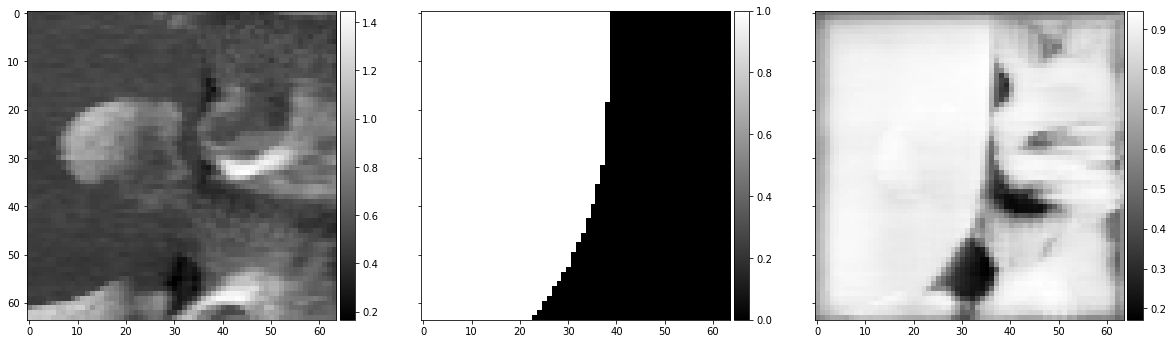

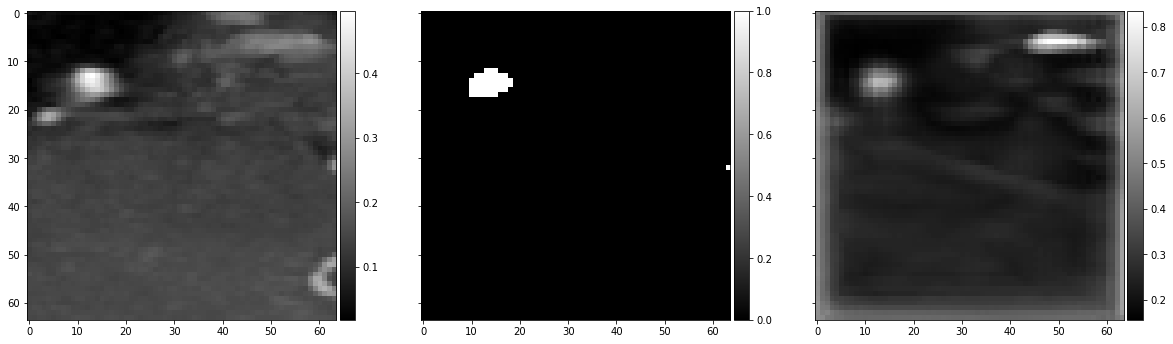

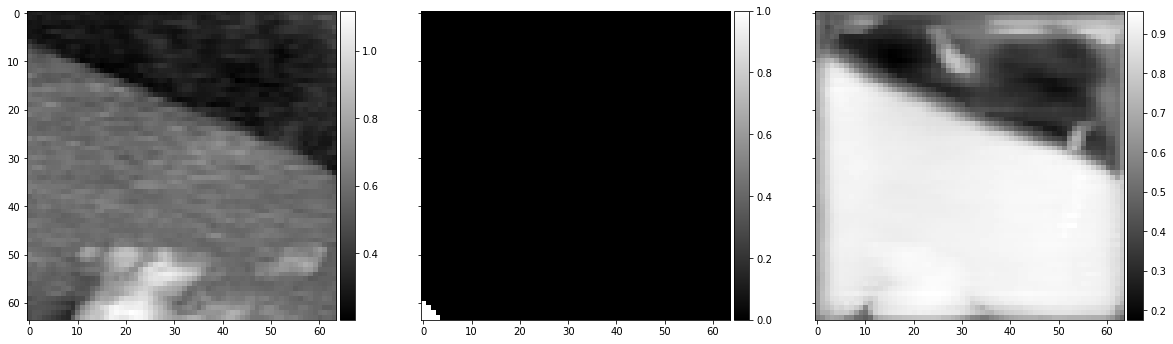

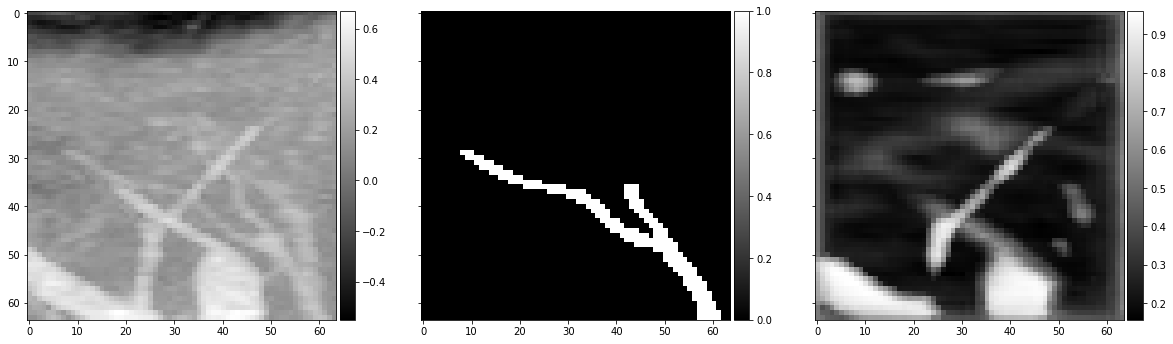

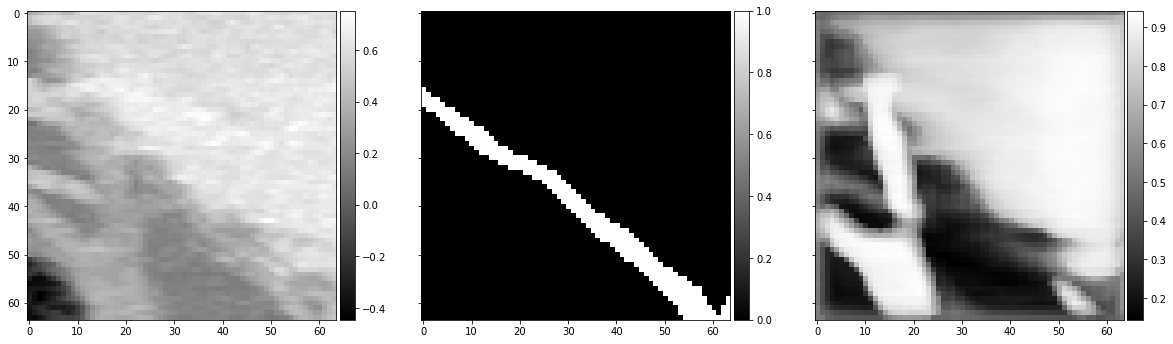

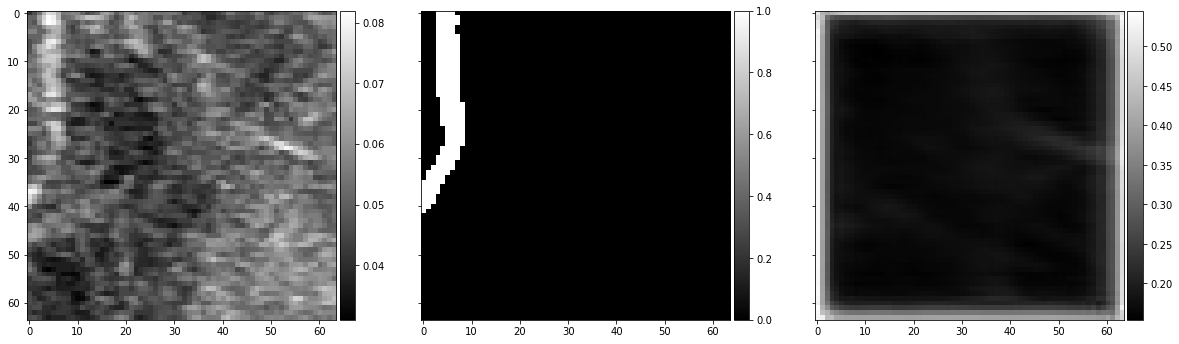

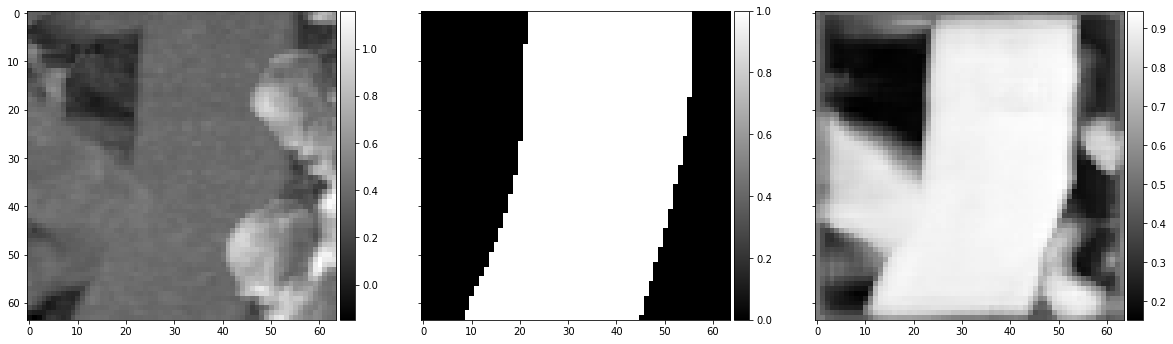

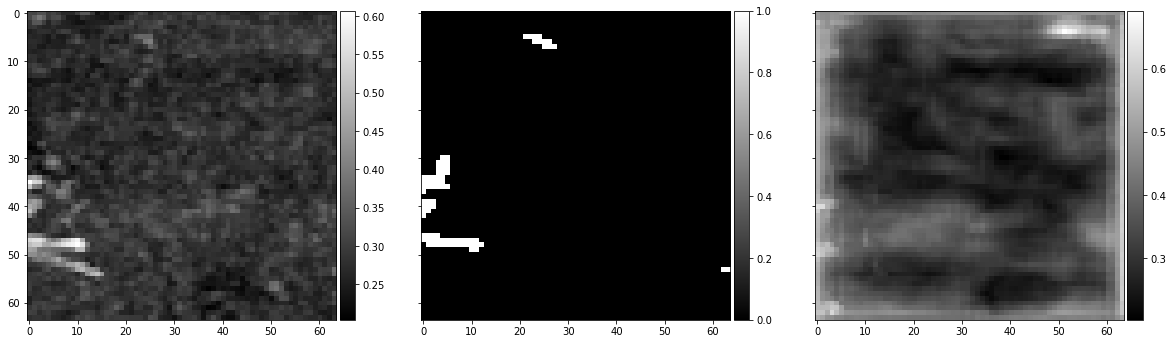

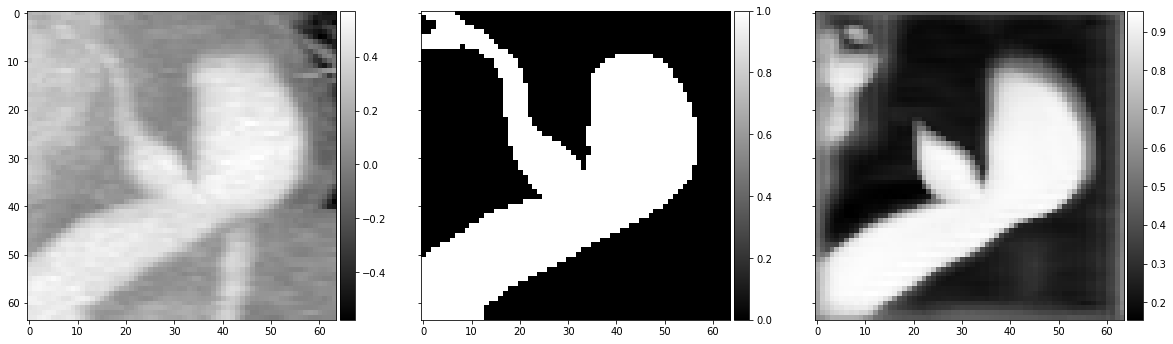

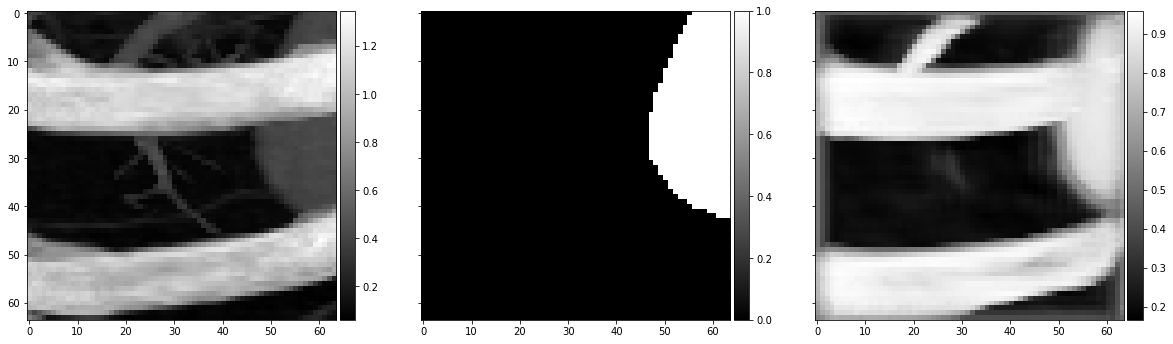

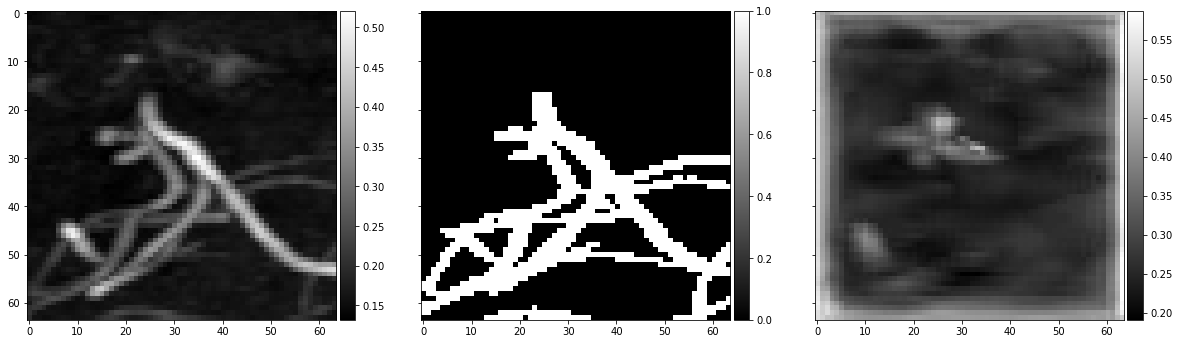

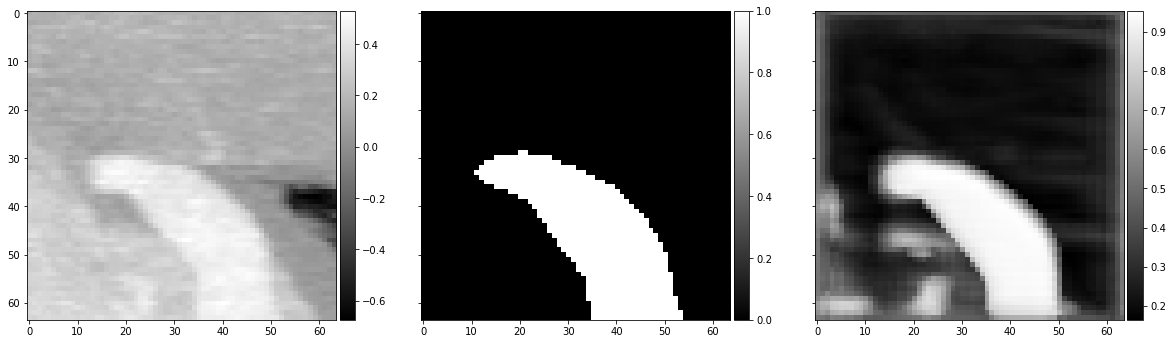

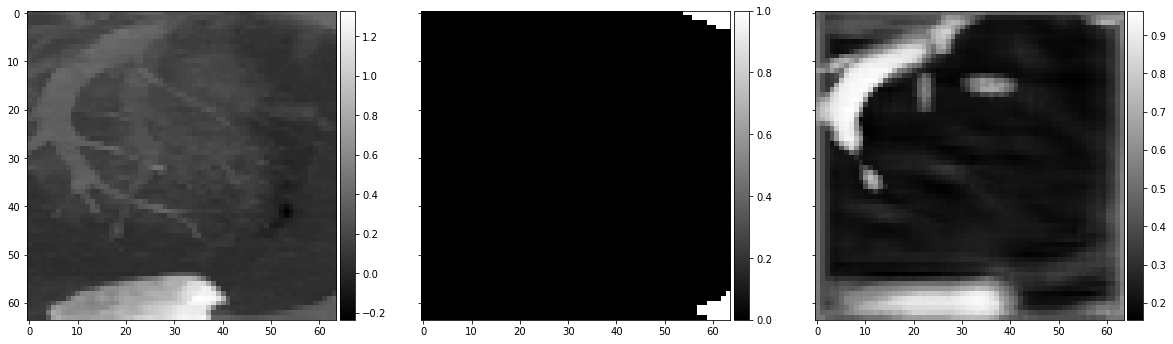

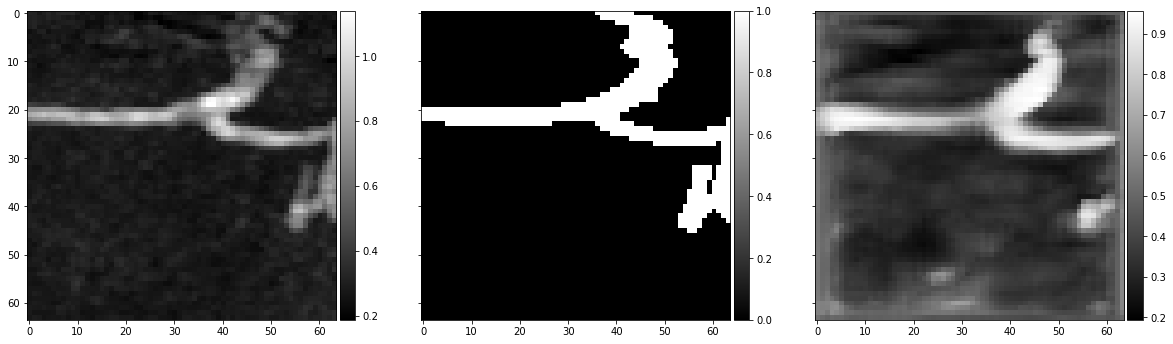

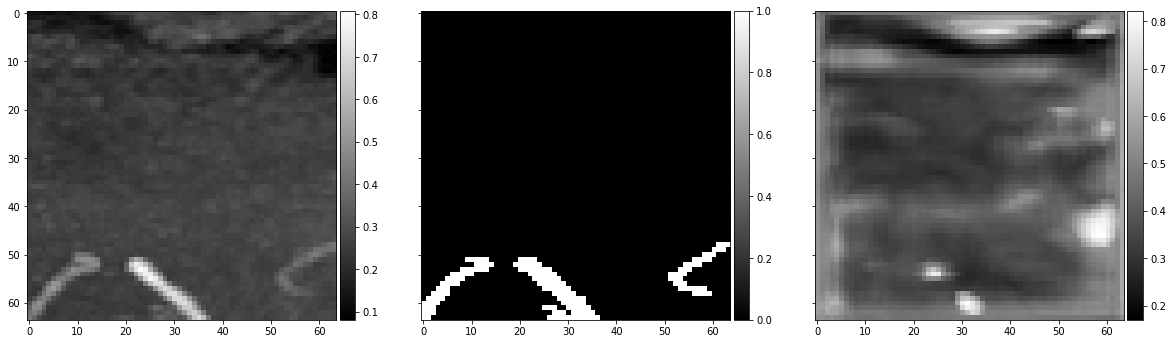

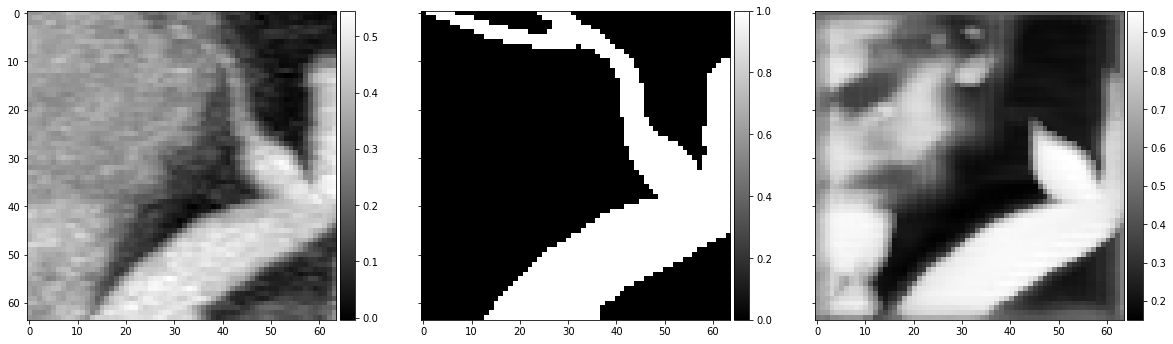

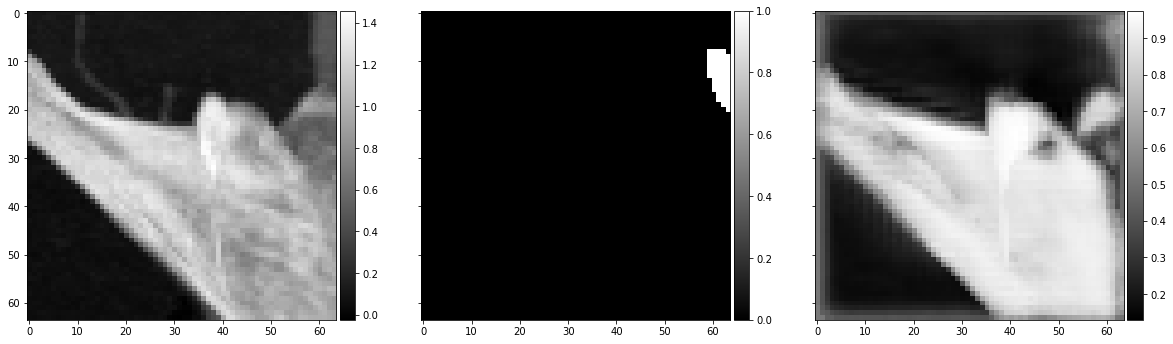

In [12]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
for i in range(len(xval)):
    j = np.random.randint(len(xval))
    mpx = np.amax(xval[j,:,:,:,0],axis=(1))
    mpy = np.amax(yval[j,:,:,:,0],axis=(1))
    mpd = np.amax(yhat[j,:,:,:,0],axis=(1))

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(mpx,ax1)
    implot(mpy,ax2)
    implot(mpd,ax3)
    plt.tight_layout
    plt.show()
    
plt.close('all')

In [ ]:
def compute_volume(net,img,DIM,STRIDE=8):
    
    W,H,D = img.shape
    N = len(range(DIM/2,W-DIM/2,STRIDE))*len(range(DIM/2,H-DIM/2,STRIDE))*len(range(DIM/2,D-DIM/2,STRIDE))
    count = 0
    patches = np.zeros((N,DIM,DIM))
    for i in range(DIM/2,W-DIM/2,STRIDE):
        print float(i)/W
        for j in range(DIM/2,H-DIM/2,STRIDE):
            for k in range(DIM/2,D-DIM/2,STRIDE):
                patches[count] = img[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]
                count+=1
                
    pred = net.predict(patches)
    
    count_mat = np.zeros((W,H,D))
    pred_image = np.zeros((W,H,D))
    
    print 'computing averaged volume'
    count = 0
    for i in range(DIM/2,W-DIM/2,STRIDE):
            print float(i)/W
            for j in range(DIM/2,H-DIM/2,STRIDE):
                for k in range(DIM/2,D-DIM/2,STRIDE):
                    count_mat[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2] += 1
                    pred_image[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2] +=\
                        1.0/count_mat[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]*\
                        (pred[count] - pred_image[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2])
                        
                    count+=1
                    
    return pred_image